# Data Preparation

## Load data from sqlite3 in json

In [1]:
from utils.db.get_data_db import get_data_json
## accuracy
from utils.information_retrieval import get_times_per_tt, get_confidence_per_tt, get_answers_scores_multiple_sel, get_answers_scores_single_sel
from utils.models import get_inference_sinlg,get_inference_multi, get_inference_multi_conf, get_inference_sinlg_part, get_inference_categ
##
from utils.models import get_times_inference, get_confidence_inference

import numpy as np

import warnings
warnings.filterwarnings('ignore')

db_file_path = 'data/study_02.db'
data = get_data_json(db_file_path)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data cleaning

Remove any incomplete registration created when participants by mistake clicked multiple times the "Registration" button.

In [2]:
data_processed = {}
for p in data:
    if data[p]['status'] == "end" or data[  p]['status'] == "end_thanks":
        data_processed[p] = data[p]

## Get observed Response Times, Accuracy, and Confidence per Task Type (TT) and group (IG, SG, AG)

<!-- There are 3 research questions in the study. -->

TT1: Does interaction help users to identify the existence or not of (strong) relations among probabilistic models’ parameters 

TT2: Does interaction help users to identify the type of relation of model’s parameters and/or predictions 

----------------------

IG: Interaction Group

SG: Static Group

AG: Animation Group

<!-- The study consisted of 3 problems. Each problem was modelled by a different probabilistic model. There were 3 sets of questions in each problem with every set corresponding to one of the research questions. -->

<!-- The task ids per problem and RQ are following:

**Problem 1: Temperature in Scotland**

RQ1: t1

RQ2: t2, t3, t4

RQ3: t5

**Problem 2: Random real-number generator**

RQ1: t6

RQ2: t7, t8, t9

RQ3: t10, t11

**Problem 3: Lorry drivers reaction times**

RQ1: t12, t13

RQ2: t14, t15, t16, t17

RQ3: t18, t19 -->

In [3]:
# task ids per TT
t_ids = {}
t_ids['T1'] = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
t_ids['T2'] = ['t11','t12','t13','t14','t15','t16']

## times
times_i, times_s, times_a = get_times_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>
## confidence
conf_i, conf_s, conf_a = get_confidence_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>

## TT1
## corr answ taken responses as multiple choice selections
answ_sc_i_multi, answ_sc_s_multi, answ_sc_a_multi = get_answers_scores_multiple_sel(data_processed, 
                                                                                                 t_ids['T1'], 
                                                                                                 db_file_path, 'T1') # returns Dict<t_id:List>
## corr answ taken responses as single selection
answ_sc_i_singl, answ_sc_s_singl, answ_sc_a_singl = get_answers_scores_single_sel(data_processed, 
                                                                                               t_ids['T1'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
## TT2
answ_sc_i_model_T2, answ_sc_s_model_T2, answ_sc_a_model_T2 = get_answers_scores_single_sel(data_processed, 
                                                                                               t_ids['T2'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
answ_sc_i_interv_T2, answ_sc_s_interv_T2, answ_sc_a_interv_T2 = get_answers_scores_multiple_sel(data_processed, 
                                                                                                 t_ids['T2'], 
                                                                                                 db_file_path, 'T2') # returns Dict<t_id:List>

In [7]:
import pymc3 as pm
def get_inference_SCO_model1(answers, t_indices, t_ids):
    """
        answers: 0s or 1s for TT1 tasks
        t_ids: List of Strings with tasks ids
    """    
    coords = {"task": t_ids}
    with pm.Model(coords=coords) as model:
        #priors
        theta = pm.Beta("theta", alpha = 1.0, beta = 1.0, dims = 'task')#probability of correct choice

        #likelihood        
        accuracy = pm.Bernoulli("accuracy", p = theta[t_indices], observed = answers)
        
        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive

def get_inference_MCO_model1(answers, n, t_indices, t_ids):
    """
        answers: List of success for all tasks in TT1
        n:         List of trials size (number of available options) per task in TT1
        t_indices: List of indexes to TT1 tasks for all observations in answers
        t_ids:     List of Strings with tasks ids
    """    
    coords = {"task": t_ids}
    with pm.Model(coords=coords) as model:
        ## priors
        theta = pm.Beta("theta", alpha = 1.0, beta = 1.0, dims = 'task')#probability of correct choice

        ## likelihood        
        accuracy = pm.Binomial("accuracy", n = n, p = theta[t_indices], observed = answers)
       
        ## inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive


# TT1
## Single Correct Option (SCO) Model 1

Takes participants together independently of the visualization condition.

Accuracy: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [31]:
## Analysis taking answers as a single option
## Responses in IG, SG, AG
ans_i = [j for _,value in answ_sc_i_singl.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_singl.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_singl.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
## task indeces 
t_indices_i = [t_ids['T1'].index(t)
               for t,value in answ_sc_i_singl.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t)
               for t,value in answ_sc_s_singl.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_singl.items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'all'
for t,value in answ_sc_i_singl.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_s_singl.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_a_singl.items():
    for j in value:
        t_indices.append(10)
#
for _,value in answ_sc_i_singl.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_singl.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_singl.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
t_atomic = ['t1','t2','t3','t4','t5']
t_shift = ['t6','t7']
t_variance = ['t8','t9','t10']
for t,value in answ_sc_i_singl.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13) 
for t,value in answ_sc_s_singl.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13) 
for t,value in answ_sc_a_singl.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
#
for _,value in answ_sc_i_singl.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_singl.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_singl.items(): 
    for j in value:
        ans.append(j)
##        
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T1_sco_m1, pp_acc_T1_sco_m1 = get_inference_SCO_model1(ans,
                                                        t_indices, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


Text(0.5, 0, 'theta')

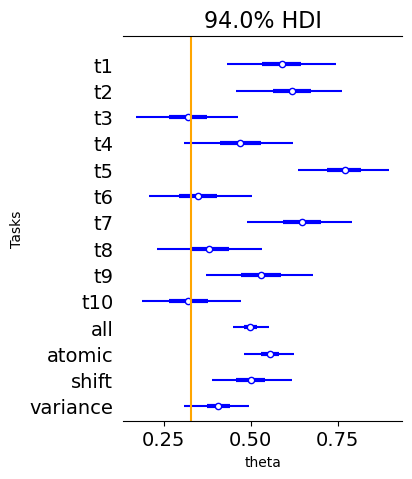

In [47]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T1_sco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance','shift','atomic','all tasks','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
# plt.savefig('ch6_Fig10_a.svg',dpi=300)

## Single Correct Option (SCO) Model 2 

Takes participants together based on visualization condition

Accuracy: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [44]:
## Analysis taking answers as a single option
## Responses in IG, SG, AG
ans_i = [j for _,value in answ_sc_i_singl.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_singl.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_singl.items() 
         for j in value]
## task indeces 
t_indices_i = [t_ids['T1'].index(t)
               for t,value in answ_sc_i_singl.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t)
               for t,value in answ_sc_s_singl.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_singl.items() 
               for j in value]
## extension for 'all'
for t,value in answ_sc_i_singl.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_singl.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_singl.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_singl.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_singl.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_singl.items(): 
    for j in value:
        ans_a.append(j)
# ## extension for 'atomic', 'shift', 'variance'
# t_atomic = ['t1','t2','t3','t4','t5']
# t_shift = ['t6','t7']
# t_variance = ['t8','t9','t10']
# for t,value in answ_sc_i_singl.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_i.append(11)
#         elif t in t_shift:
#             t_indices_i.append(12)
#         elif t in t_variance:
#             t_indices_i.append(13) 
# for t,value in answ_sc_s_singl.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_s.append(11)
#         elif t in t_shift:
#             t_indices_s.append(12)
#         elif t in t_variance:
#             t_indices_s.append(13) 
# for t,value in answ_sc_a_singl.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_a.append(11)
#         elif t in t_shift:
#             t_indices_a.append(12)
#         elif t in t_variance:
#             t_indices_a.append(13)
# #
# for _,value in answ_sc_i_singl.items(): 
#     for j in value:
#         ans_i.append(j)
# for _,value in answ_sc_s_singl.items():
#     for j in value:
#         ans_s.append(j)
# for _,value in answ_sc_a_singl.items(): 
#     for j in value:
#         ans_a.append(j)
##        
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
# t_id.append('atomic')
# t_id.append('shift')
# t_id.append('variance')
trace_acc_T1_sc0_m2, pp_acc_T1_sc0_m2 = get_inference_sinlg(ans_i, 
                                                        ans_s,
                                                        ans_a,
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_indices_a, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


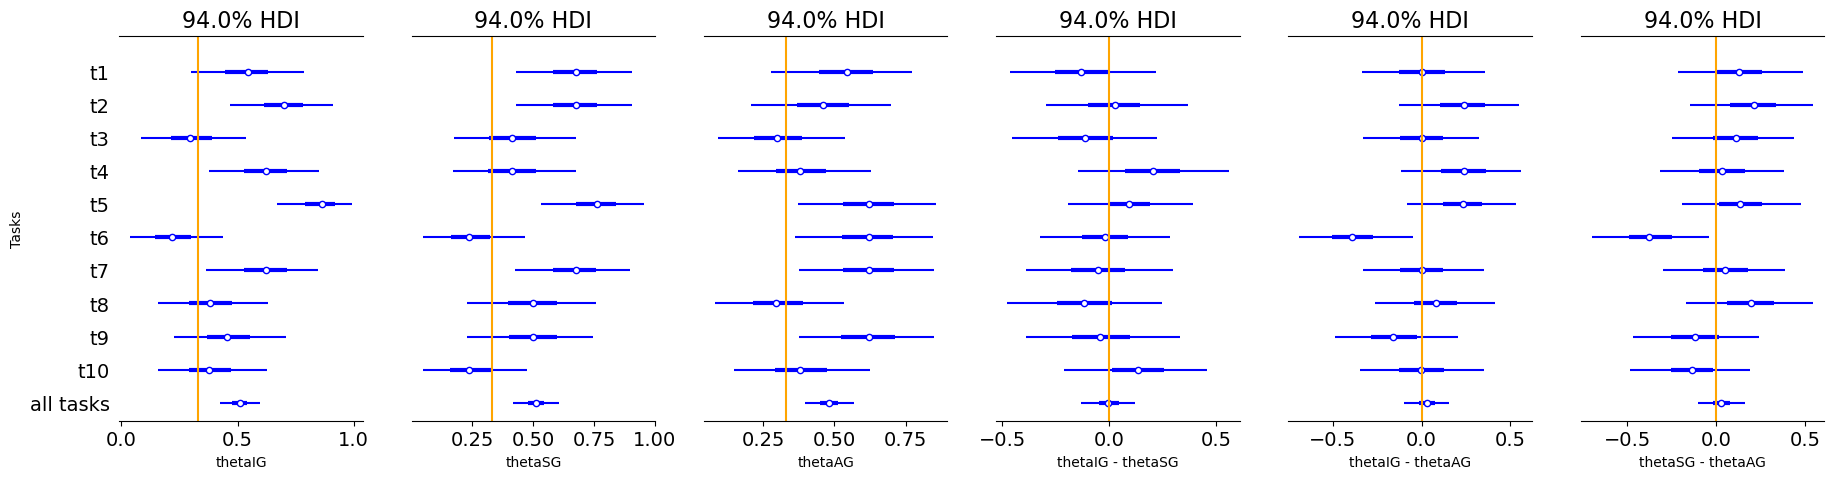

In [45]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_sc0_m2)
prob = 0.94
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, hdi_prob = prob, colors = 'blue')
ax[0].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, hdi_prob = prob, colors = 'blue')
ax[1].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, hdi_prob = prob, colors = 'blue')
ax[2].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, hdi_prob = prob, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, hdi_prob = prob, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, hdi_prob = prob, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
# ax[0].set_yticklabels(['variance','shift','atomic','all','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax[0].set_yticklabels(['all tasks','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
# plt.savefig('ch6_Fig10_b.svg',dpi=300)

## Multiple Correct Options (MCO) Model 1 

Takes participants together independently of visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [36]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_multi.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_multi.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_multi.items() 
       for j in value]
n = n_i+n_s+n_a
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
t_indices = t_indices_a+t_indices_s+t_indices_a
## extension for 'all'
for i in range(len(n_i)):
    n.append(2)
for i in range(len(n_s)):
    n.append(2)
for i in range(len(n_a)):
    n.append(2)
#
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
for t,value in answ_sc_i_multi.items(): 
    for j in value:
        n.append(2)
for t,value in answ_sc_s_multi.items(): 
    for j in value:
        n.append(2)
for t,value in answ_sc_a_multi.items(): 
    for j in value:
        n.append(2)
#
t_atomic = ['t1','t2','t3','t4','t5']
t_shift = ['t6','t7']
t_variance = ['t8','t9','t10']
for t,value in answ_sc_i_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
for t,value in answ_sc_s_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
for t,value in answ_sc_a_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans.append(j)
##
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T1_mco_m1, pp_acc_T1_mco_m1 = get_inference_MCO_model1(ans,
                                                n, 
                                                t_indices,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


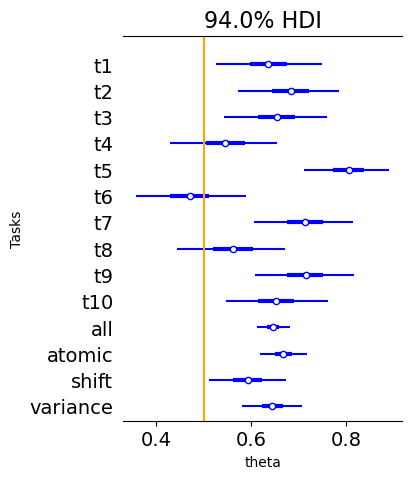

In [39]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T1_mco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance','shift','atomic','all tasks','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
# plt.savefig('ch6_Fig10_c.svg',dpi=300)

## Multiple Correct Options (MCO) Model 2 

Takes participants together based on visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [41]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_multi.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_multi.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_multi.items() 
       for j in value]
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
## extension for 'all'
for i in range(len(n_i)):
    n_i.append(2)
for i in range(len(n_s)):
    n_s.append(2)
for i in range(len(n_a)):
    n_a.append(2)
#
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
# ## extension for 'atomic', 'shift', 'variance'
# for t,value in answ_sc_i_multi.items(): 
#     for j in value:
#         n_i.append(2)
# for t,value in answ_sc_s_multi.items(): 
#     for j in value:
#         n_s.append(2)
# for t,value in answ_sc_a_multi.items(): 
#     for j in value:
#         n_a.append(2)
# #
# t_atomic = ['t1','t2','t3','t4','t5']
# t_shift = ['t6','t7']
# t_variance = ['t8','t9','t10']
# for t,value in answ_sc_i_multi.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_i.append(11)
#         elif t in t_shift:
#             t_indices_i.append(12)
#         elif t in t_variance:
#             t_indices_i.append(13)
# for t,value in answ_sc_s_multi.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_s.append(11)
#         elif t in t_shift:
#             t_indices_s.append(12)
#         elif t in t_variance:
#             t_indices_s.append(13)
# for t,value in answ_sc_a_multi.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_a.append(11)
#         elif t in t_shift:
#             t_indices_a.append(12)
#         elif t in t_variance:
#             t_indices_a.append(13)
# #
# for _,value in answ_sc_i_multi.items(): 
#     for j in value:
#         ans_i.append(j)
# for _,value in answ_sc_s_multi.items():
#     for j in value:
#         ans_s.append(j)
# for _,value in answ_sc_a_multi.items(): 
#     for j in value:
#         ans_a.append(j)
#
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
# t_id.append('atomic')
# t_id.append('shift')
# t_id.append('variance')
trace_acc_T1_mco_m2, pp_acc_T1_mco_m2 = get_inference_multi(ans_i, ans_s, ans_a,
                                                n_i, n_s, n_a, 
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


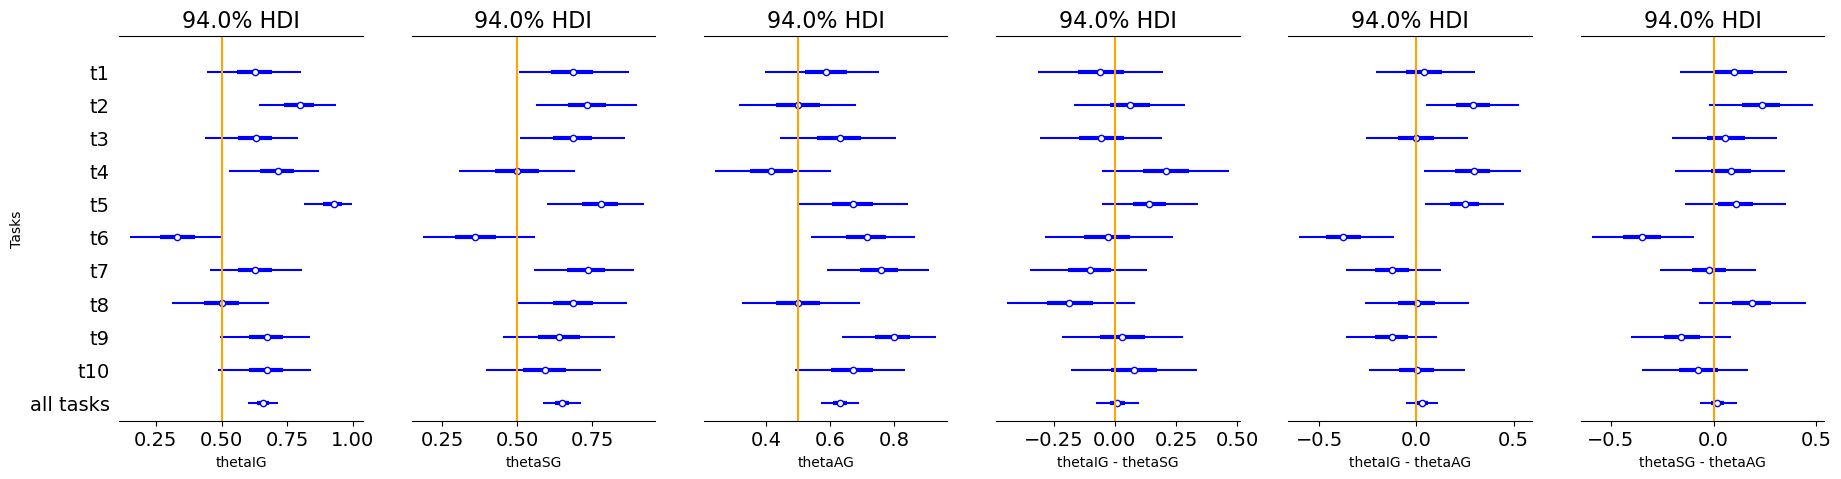

In [42]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_mco_m2)
prob = 0.94
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, hdi_prob = prob, colors = 'blue')
ax[0].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, hdi_prob = prob, colors = 'blue')
ax[1].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, hdi_prob = prob, colors = 'blue')
ax[2].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, hdi_prob = prob, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, hdi_prob = prob, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, hdi_prob = prob, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
# ax[0].set_yticklabels(['variance','shift','atomic','all','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax[0].set_yticklabels(['all tasks','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
# plt.savefig('ch6_Fig10_d.svg',dpi=300)

# TT2
## Single Correct Option (SCO) - Model 1
Model Decision

Taking all participants independently of the visualization mode.

Acc: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [50]:
## Analysis taking answers as a single option
# interactive, static, and animated answers
ans_i = [j for _,value in answ_sc_i_model_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_model_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_model_T2.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
#indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_model_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_model_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_model_T2.items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'all'
for t,value in answ_sc_i_model_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_s_model_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_a_model_T2.items():
    for j in value:
        t_indices.append(6)
#
for _,value in answ_sc_i_model_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_model_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_model_T2.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
t_atomic = ['t11','t12']
t_shift = ['t13','t14']
t_variance = ['t15','t16']
for t,value in answ_sc_i_model_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9) 
for t,value in answ_sc_s_model_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9) 
for t,value in answ_sc_a_model_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
#
for _,value in answ_sc_i_model_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_model_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_model_T2.items(): 
    for j in value:
        ans.append(j)
##
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T2_sco_m1, pp_acc_T2_sco_m1 = get_inference_SCO_model1(ans,
                                                        t_indices, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


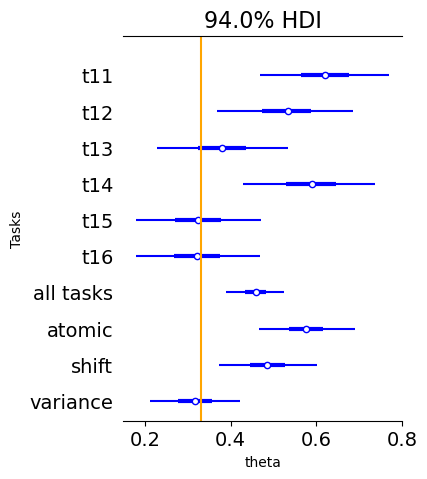

In [58]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T2_sco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance','shift','atomic','all tasks','t16','t15','t14','t13','t12','t11'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
plt.savefig('ch6_Fig11_a.svg',dpi=300)

## Single Correct Option (SCO) - Model 2
Model Decision

Taking all participants based on the visualization mode.

Acc: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [53]:
## Analysis taking answers as a single option
# interactive, static, and animated answers
ans_i = [j for _,value in answ_sc_i_model_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_model_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_model_T2.items() 
         for j in value]
#indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_model_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_model_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_model_T2.items() 
               for j in value]
## extension for 'all'
for t,value in answ_sc_i_model_T2.items():
    for j in value:
        t_indices_i.append(6)
for t,value in answ_sc_s_model_T2.items():
    for j in value:
        t_indices_s.append(6)
for t,value in answ_sc_a_model_T2.items():
    for j in value:
        t_indices_a.append(6)
#
for _,value in answ_sc_i_model_T2.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_model_T2.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_model_T2.items(): 
    for j in value:
        ans_a.append(j)
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
trace_acc_T2_sco_m2, pp_acc_T2_sco_m2 = get_inference_sinlg(ans_i, 
                                                        ans_s,
                                                        ans_a,
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_indices_a, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


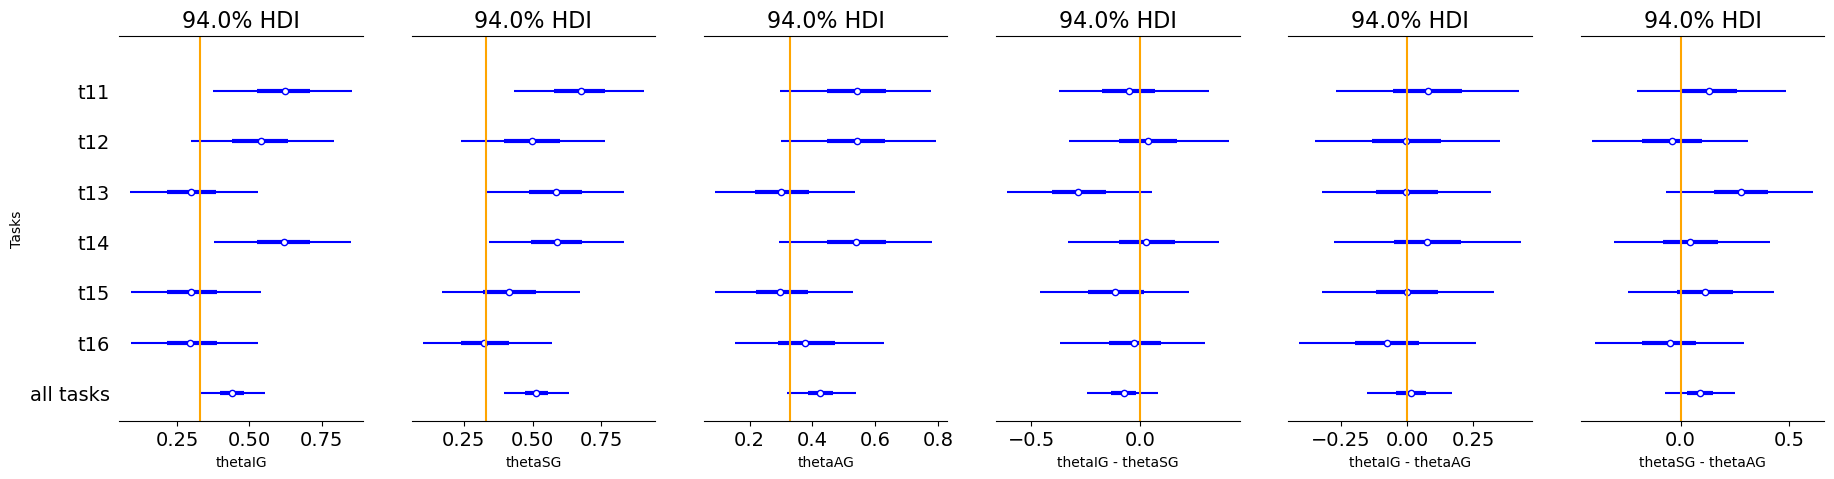

In [57]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T2_sco_m2)
# ai['posterior']
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, colors = 'blue')
ax[0].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, colors = 'blue')
ax[1].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, colors = 'blue')
ax[2].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax[0].set_yticklabels(['all tasks','t16','t15','t14','t13','t12','t11'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
plt.savefig('ch6_Fig11_b.svg', dpi=300)

## Multiple Correct Options (MCO) Model 1 

Takes participants together independently of visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [8]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_interv_T2.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_interv_T2.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_interv_T2.items() 
       for j in value]
n = n_i+n_s+n_a
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_interv_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_interv_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_interv_T2.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
## indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_interv_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_interv_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_interv_T2.items() 
               for j in value]
t_indices = t_indices_a+t_indices_s+t_indices_a
## extension for 'all'
for i in range(len(n_i)):
    n.append(2)
for i in range(len(n_s)):
    n.append(2)
for i in range(len(n_a)):
    n.append(2)
#
for t,value in answ_sc_i_interv_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_s_interv_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_a_interv_T2.items():
    for j in value:
        t_indices.append(6)
#
for _,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_interv_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
for t,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        n.append(2)
for t,value in answ_sc_s_interv_T2.items(): 
    for j in value:
        n.append(2)
for t,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        n.append(2)
#
t_atomic = ['t11','t12']
t_shift = ['t13','t14']
t_variance = ['t15','t16']
for t,value in answ_sc_i_interv_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
for t,value in answ_sc_s_interv_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
for t,value in answ_sc_a_interv_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
#
for _,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_interv_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        ans.append(j)
##
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
# trace_acc_T2_mco_m1, pp_acc_T2_mco_m1 = get_inference_MCO_model1(ans,
#                                                 n, 
#                                                 t_indices,
#                                                 t_id)

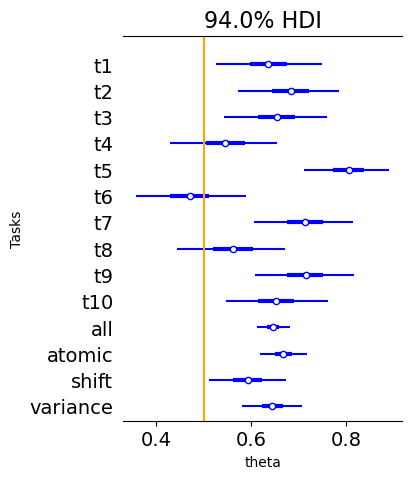

In [39]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T2_mco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance','shift','atomic','all tasks','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
# plt.savefig('ch6_Fig10_c.svg',dpi=300)

## Multiple Correct Options (MCO) Model 2 

Takes participants together based on visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [ ]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_interv_T2.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_interv_T2.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_interv_T2.items() 
       for j in value]
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_interv_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_interv_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_interv_T2.items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_interv_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_interv_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_interv_T2.items() 
               for j in value]
## extension for 'all'
for i in range(len(n_i)):
    n_i.append(2)
for i in range(len(n_s)):
    n_s.append(2)
for i in range(len(n_a)):
    n_a.append(2)
#
for t,value in answ_sc_i_interv_T2.items():
    for j in value:
        t_indices_i.append(6)
for t,value in answ_sc_s_interv_T2.items():
    for j in value:
        t_indices_s.append(6)
for t,value in answ_sc_a_interv_T2.items():
    for j in value:
        t_indices_a.append(6)
#
for _,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_interv_T2.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        ans_a.append(j)
#
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
trace_acc_T2_mco_m2, pp_acc_T2_mco_m2 = get_inference_multi(ans_i, ans_s, ans_a,
                                                n_i, n_s, n_a, 
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


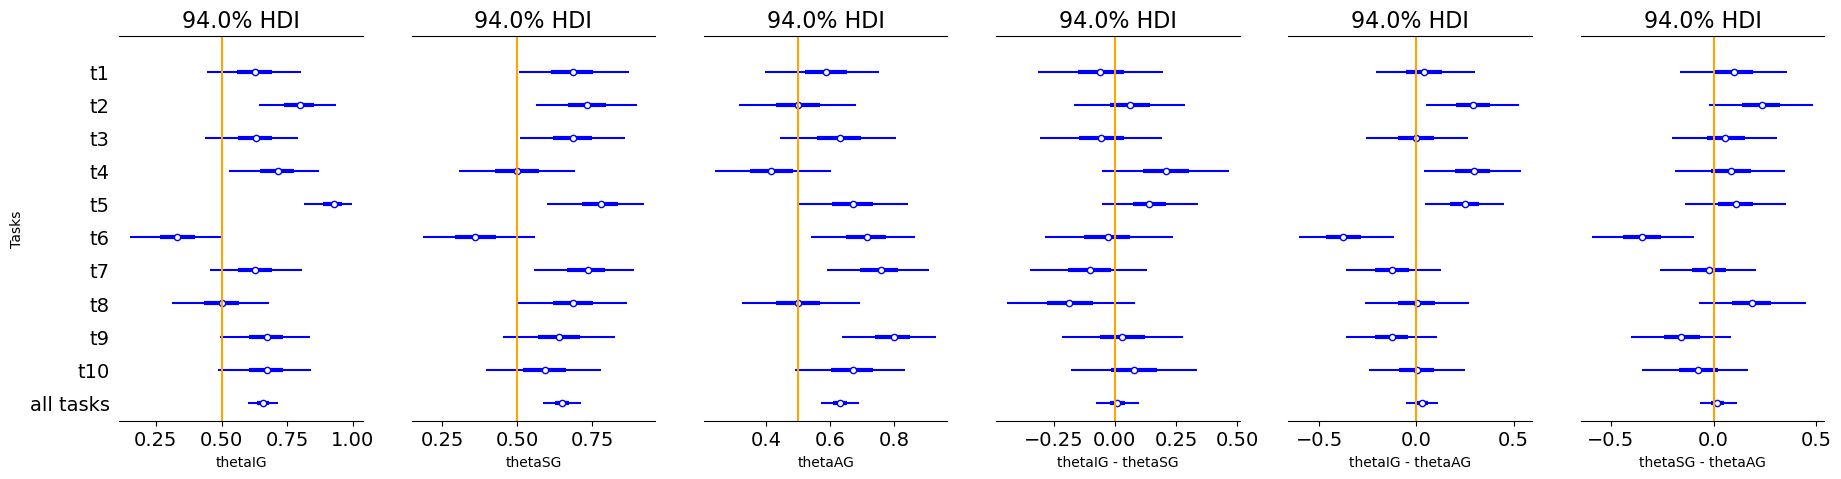

In [42]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_mco_m2)
prob = 0.94
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, hdi_prob = prob, colors = 'blue')
ax[0].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, hdi_prob = prob, colors = 'blue')
ax[1].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, hdi_prob = prob, colors = 'blue')
ax[2].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, hdi_prob = prob, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, hdi_prob = prob, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, hdi_prob = prob, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
# ax[0].set_yticklabels(['variance','shift','atomic','all','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax[0].set_yticklabels(['all tasks','t10','t9','t8','t7','t6','t5','t4','t3','t2','t1'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
# plt.savefig('ch6_Fig11_d.svg',dpi=300)

## Analysis 3 - Correcting Accuracy by Confidence
Acc: 

0  If hamming distance = 0 

1  If hamming distance = 1

2  If hamming distance = 2

Correct theta by confidence

In [4]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_multi.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_multi.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_multi.items() 
       for j in value]
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
c_i = [j for _,value in conf_i['T1'].items() 
         for j in value]
c_s = [j for _,value in conf_s['T1'].items() 
         for j in value]
c_a = [j for _,value in conf_a['T1'].items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
## extension for 'all'
for i in range(len(n_i)):
    n_i.append(2)
for i in range(len(n_s)):
    n_s.append(2)
for i in range(len(n_a)):
    n_a.append(2)
#
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
for _,value in conf_i['T1'].items(): 
    for j in value:
        c_i.append(j)
for _,value in conf_s['T1'].items():
    for j in value:
        c_s.append(j)
for _,value in conf_a['T1'].items(): 
    for j in value:
        c_a.append(j)
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
trace_acc_T1_multi_conf, pp_acc_T1_multi_conf = get_inference_multi_conf(ans_i, ans_s, ans_a, c_i, c_s, c_a,
                                                n_i, n_s, n_a, 
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k0, thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
There were 1828 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1920 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1708 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1890 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Text(0.5, 0, 'SG-AG')

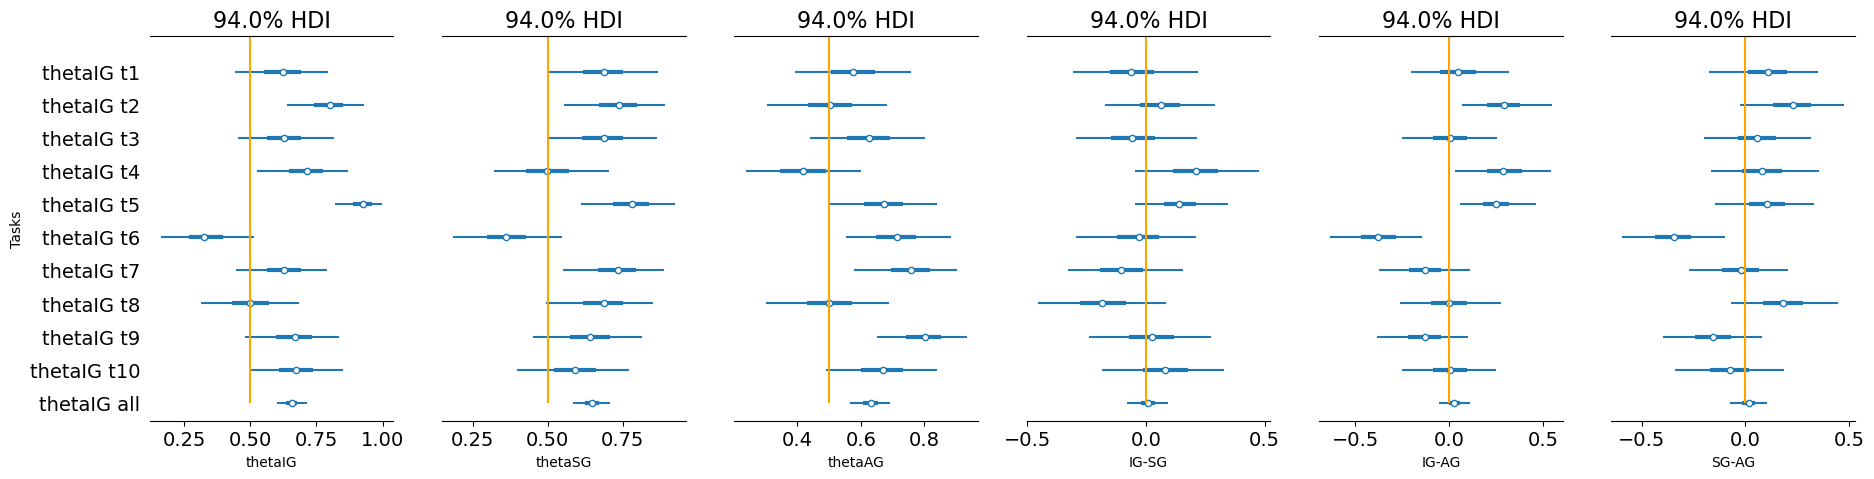

In [5]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_multi_conf)
# ai['posterior']
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True)
ax[0].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True)
ax[1].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True)
ax[2].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True)
ax[3].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True)
ax[4].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True)
ax[5].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("IG-SG")
ax[4].set_xlabel("IG-AG")
ax[5].set_xlabel("SG-AG")

## Analysis 4 - Inference on the participant level
Acc: 

0  If hamming distance = 0 

1  If hamming distance = 1

2  If hamming distance = 2

Estimate theta per participant

In [11]:
## Analysis taking answers as a single option
# interactive, static, and animated answers
ans_i = [j for _,value in answ_sc_i_singl.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_singl.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_singl.items() 
         for j in value]
#indices 
t_indices_i = [i
               for t,value in answ_sc_i_singl.items() 
               for i,j in enumerate(value)]
num_p_i = len(answ_sc_i_singl['t1'])
t_indices_s = [i
               for t,value in answ_sc_s_singl.items() 
               for i,j in enumerate(value)]
num_p_s = len(answ_sc_s_singl['t1'])
t_indices_a = [i
               for t,value in answ_sc_a_singl.items() 
               for i,j in enumerate(value)]
num_p_a = len(answ_sc_a_singl['t1'])
##
t_id_i = []
for p in range(num_p_i):
    t_id_i.append('p'+str(p))
t_id_s = []
for p in range(num_p_s):
    t_id_s.append('p'+str(p+num_p_i))
t_id_a = []
for p in range(num_p_a):
    t_id_a.append('p'+str(p+num_p_i+num_p_s))
trace_acc_T1_singl_part_i, pp_acc_T1_singl_part_i = get_inference_sinlg_part(ans_i, t_indices_i, t_id_i)
trace_acc_T1_singl_part_s, pp_acc_T1_singl_part_s = get_inference_sinlg_part(ans_s, t_indices_s, t_id_s)
trace_acc_T1_singl_part_a, pp_acc_T1_singl_part_a = get_inference_sinlg_part(ans_a, t_indices_a, t_id_a)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 44 seconds.


Text(0.5, 0, 'thetaAG')

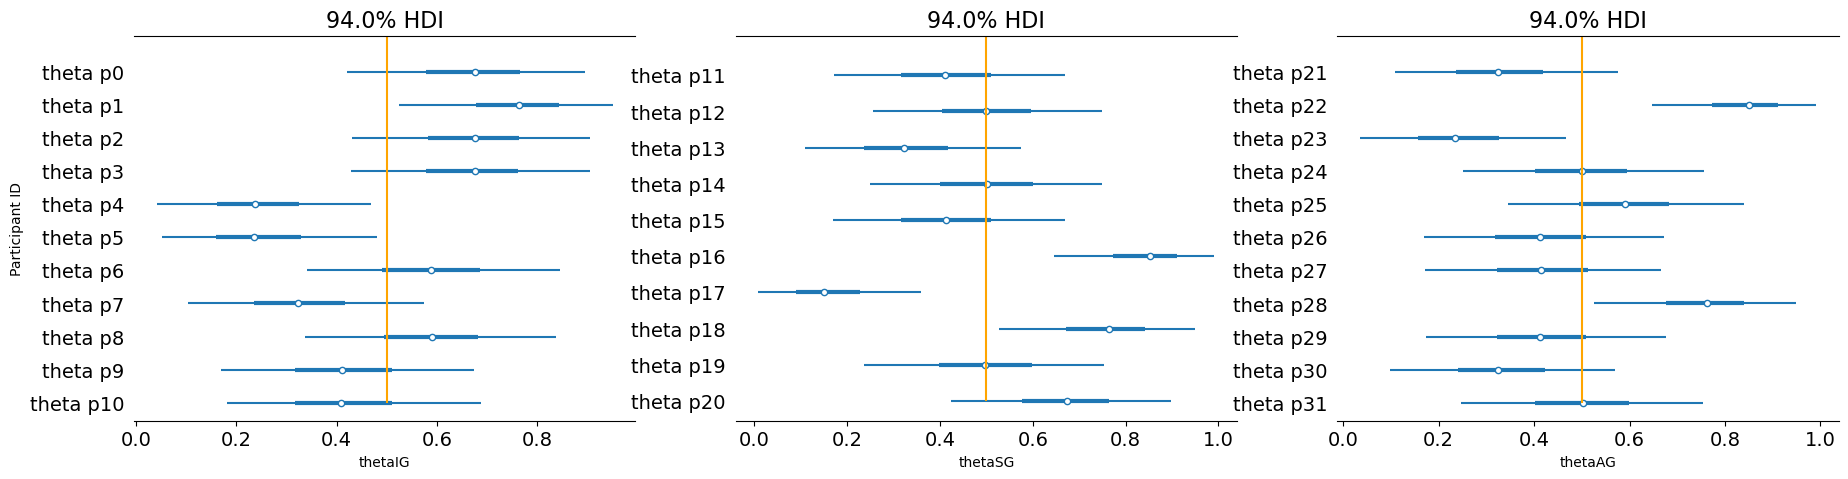

In [12]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_singl_part_i)
a_s = az.from_pymc3(trace_acc_T1_singl_part_s)
aa = az.from_pymc3(trace_acc_T1_singl_part_a)
y_max = 11
# ai['posterior']
az.plot_forest(ai['posterior']['theta'], ax = ax[0], combined = True)
ax[0].vlines(x = 0.5, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(a_s['posterior']['theta'], ax = ax[1], combined = True)
ax[1].vlines(x = 0.5, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(aa['posterior']['theta'], ax = ax[2], combined = True)
ax[2].vlines(x = 0.5, ymin = 0, ymax = y_max, colors = 'orange')
# az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True)
# ax[3].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
# az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True)
# ax[4].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
# az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True)
# ax[5].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
# ax[1].get_yaxis().set_visible(False)
# ax[2].get_yaxis().set_visible(False)
# ax[3].get_yaxis().set_visible(False)
# ax[4].get_yaxis().set_visible(False)
# ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Participant ID")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
# ax[3].set_xlabel("IG-SG")
# ax[4].set_xlabel("IG-AG")
# ax[5].set_xlabel("SG-AG")

## Analysis 5 - Categorical Likelihood
Acc: 

0  If hamming distance = 0 

1  If hamming distance = 1

2  If hamming distance = 2


In [5]:
import pymc3 as pm
def get_inference_categ(answers_i, answers_s, answers_a, t_indices_i, t_indices_s, t_indices_a, t_ids):
    """
        answers_i: List of success for all tasks in rq1 for all interactive participants
        n:         List of trials size (number of available options) per task in rq1
        t_indices: List of indexes to rq1 tasks for all observations in answers_i or answers_s
        t_ids:     List of Strings with tasks ids
    """    
    coords = {"task": t_ids}
    with pm.Model(coords=coords) as model:
        #priors
        pIG = pm.Dirichlet("pIG", a=np.tile(np.array([0.5,0.5,0.5]),(14,1)))#probability of correct choice ti, 'all', 'atomic', 'shift', 'variance'
        pSG = pm.Dirichlet("pSG", a=np.tile(np.array([0.5,0.5,0.5]),(14,1)))
        pAG = pm.Dirichlet("pAG", a=np.tile(np.array([0.5,0.5,0.5]),(14,1)))

        #likelihood        
        accuracyIG = pm.Categorical("accuracyIG", p = pIG[t_indices_i], observed = answers_i)
        accuracySG = pm.Categorical("accuracySG", p = pSG[t_indices_s], observed = answers_s)
        accuracyAG = pm.Categorical("accuracyAG", p = pAG[t_indices_a], observed = answers_a)
        
        #comparisons
        # diff_of_thetas_IG_SG = pm.Deterministic("difference of thetas IG-SG", thetaIG - thetaSG, dims='task')
        # diff_of_thetas_IG_AG = pm.Deterministic("difference of thetas IG-AG", thetaIG - thetaAG, dims='task')
        # diff_of_thetas_SG_AG = pm.Deterministic("difference of thetas SG-AG", thetaSG - thetaAG, dims='task')
       
        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive

## Responses of IG, SG, AG
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
## Extension for 'all'
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
## Extention for 'atomic', 'shift', 'variance'
t_atomic = ['t1','t2','t3','t4','t5']
t_shift = ['t6','t7']
t_variance = ['t8','t9','t10']
for t,value in answ_sc_i_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices_i.append(11)
        elif t in t_shift:
            t_indices_i.append(12)
        elif t in t_variance:
            t_indices_i.append(13)
for t,value in answ_sc_s_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices_s.append(11)
        elif t in t_shift:
            t_indices_s.append(12)
        elif t in t_variance:
            t_indices_s.append(13)
for t,value in answ_sc_a_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices_a.append(11)
        elif t in t_shift:
            t_indices_a.append(12)
        elif t in t_variance:
            t_indices_a.append(13)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
## 
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
trace_acc_T1_multi_cat, pp_acc_T1_multi_cat = get_inference_categ(ans_i, ans_s, ans_a,
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pAG, pSG, pIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 71 seconds.


### Plot Forest Plot of Posterior Predictive Samples

In [23]:
pp_data = {'IG':{},'AG':{},'SG':{}}
pp_data['IG']['t1'] = pp_acc_T1_multi_cat['accuracyIG'][:,0:11].flatten()
pp_data['IG']['t2'] = pp_acc_T1_multi_cat['accuracyIG'][:,11:22].flatten()
pp_data['IG']['t3'] = pp_acc_T1_multi_cat['accuracyIG'][:,22:33].flatten()
pp_data['IG']['t4'] = pp_acc_T1_multi_cat['accuracyIG'][:,33:44].flatten()
pp_data['IG']['t5'] = pp_acc_T1_multi_cat['accuracyIG'][:,44:55].flatten()
pp_data['IG']['t6'] = pp_acc_T1_multi_cat['accuracyIG'][:,55:66].flatten()
pp_data['IG']['t7'] = pp_acc_T1_multi_cat['accuracyIG'][:,66:77].flatten()
pp_data['IG']['t8'] = pp_acc_T1_multi_cat['accuracyIG'][:,77:88].flatten()
pp_data['IG']['t9'] = pp_acc_T1_multi_cat['accuracyIG'][:,88:99].flatten()
pp_data['IG']['t10'] = pp_acc_T1_multi_cat['accuracyIG'][:,99:110].flatten()
pp_data['IG']['all'] = pp_acc_T1_multi_cat['accuracyIG'][:,110:220].flatten()
pp_data['IG']['atomic'] = pp_acc_T1_multi_cat['accuracyIG'][:,220:275].flatten()
pp_data['IG']['shift'] = pp_acc_T1_multi_cat['accuracyIG'][:,275:297].flatten()
pp_data['IG']['variance'] = pp_acc_T1_multi_cat['accuracyIG'][:,297:330].flatten()
pp_data['SG']['t1'] = pp_acc_T1_multi_cat['accuracySG'][:,0:10].flatten()
pp_data['SG']['t2'] = pp_acc_T1_multi_cat['accuracySG'][:,10:20].flatten()
pp_data['SG']['t3'] = pp_acc_T1_multi_cat['accuracySG'][:,20:30].flatten()
pp_data['SG']['t4'] = pp_acc_T1_multi_cat['accuracySG'][:,30:40].flatten()
pp_data['SG']['t5'] = pp_acc_T1_multi_cat['accuracySG'][:,40:50].flatten()
pp_data['SG']['t6'] = pp_acc_T1_multi_cat['accuracySG'][:,50:60].flatten()
pp_data['SG']['t7'] = pp_acc_T1_multi_cat['accuracySG'][:,60:70].flatten()
pp_data['SG']['t8'] = pp_acc_T1_multi_cat['accuracySG'][:,70:80].flatten()
pp_data['SG']['t9'] = pp_acc_T1_multi_cat['accuracySG'][:,80:90].flatten()
pp_data['SG']['t10'] = pp_acc_T1_multi_cat['accuracySG'][:,90:100].flatten()
pp_data['SG']['all'] = pp_acc_T1_multi_cat['accuracySG'][:,100:200].flatten()
pp_data['SG']['atomic'] = pp_acc_T1_multi_cat['accuracySG'][:,200:250].flatten()
pp_data['SG']['shift'] = pp_acc_T1_multi_cat['accuracySG'][:,250:270].flatten()
pp_data['SG']['variance'] = pp_acc_T1_multi_cat['accuracySG'][:,270:300].flatten()
pp_data['AG']['t1'] = pp_acc_T1_multi_cat['accuracyAG'][:,0:11].flatten()
pp_data['AG']['t2'] = pp_acc_T1_multi_cat['accuracyAG'][:,11:22].flatten()
pp_data['AG']['t3'] = pp_acc_T1_multi_cat['accuracyAG'][:,22:33].flatten()
pp_data['AG']['t4'] = pp_acc_T1_multi_cat['accuracyAG'][:,33:44].flatten()
pp_data['AG']['t5'] = pp_acc_T1_multi_cat['accuracyAG'][:,44:55].flatten()
pp_data['AG']['t6'] = pp_acc_T1_multi_cat['accuracyAG'][:,55:66].flatten()
pp_data['AG']['t7'] = pp_acc_T1_multi_cat['accuracyAG'][:,66:77].flatten()
pp_data['AG']['t8'] = pp_acc_T1_multi_cat['accuracyAG'][:,77:88].flatten()
pp_data['AG']['t9'] = pp_acc_T1_multi_cat['accuracyAG'][:,88:99].flatten()
pp_data['AG']['t10'] = pp_acc_T1_multi_cat['accuracyAG'][:,99:110].flatten()
pp_data['AG']['all'] = pp_acc_T1_multi_cat['accuracyAG'][:,110:220].flatten()
pp_data['AG']['atomic'] = pp_acc_T1_multi_cat['accuracyAG'][:,220:275].flatten()
pp_data['AG']['shift'] = pp_acc_T1_multi_cat['accuracyAG'][:,275:297].flatten()
pp_data['AG']['variance'] = pp_acc_T1_multi_cat['accuracyAG'][:,297:330].flatten()
# import arviz as az
# xarray_IG = az.convert_to_dataset(pp_data['IG']) 
# xarray_SG = az.convert_to_dataset(pp_data['SG']) 
# xarray_AG = az.convert_to_dataset(pp_data['AG']) 
# data_pp = az.convert_to_inference_data(xarray_IG, group = 'IG')
# data_pp.add_groups({'SG':xarray_SG,'AG':xarray_AG})
# data_pp
pp_data['AG']['all'].std()

0.7951762582171522

Text(0.5, 0, 'pAG Hamm. = 0')

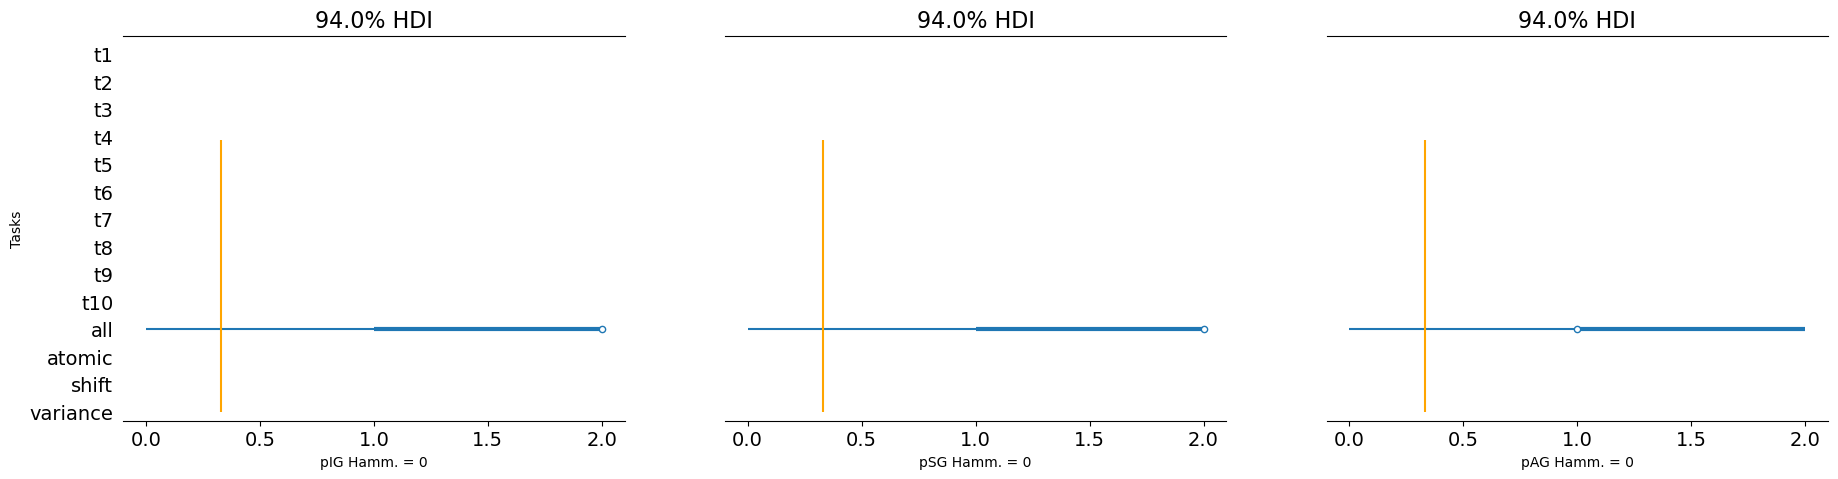

In [19]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(22, 5))

# ai['posterior']
y_max = 40
az.plot_forest(data_pp['IG'], ax = ax[0], combined = True)
ax[0].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pp['SG'], ax = ax[1], combined = True)
ax[1].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pp['AG'], ax = ax[2], combined = True)
ax[2].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("pIG Hamm. = 0")
ax[1].set_xlabel("pSG Hamm. = 0")
ax[2].set_xlabel("pAG Hamm. = 0")

### Plot Error Bars

In [29]:
import pandas as pd
data_categ = {'condition':[], 'accuracy':[], 'task':[]}
for group in pp_data:
    for t in pp_data[group]:
        for v in pp_data[group][t]:
            data_categ['condition'].append(group)
            data_categ['task'].append(t)
            data_categ['accuracy'].append(v)
df = pd.DataFrame(data_categ)

<AxesSubplot: xlabel='accuracy', ylabel='task'>

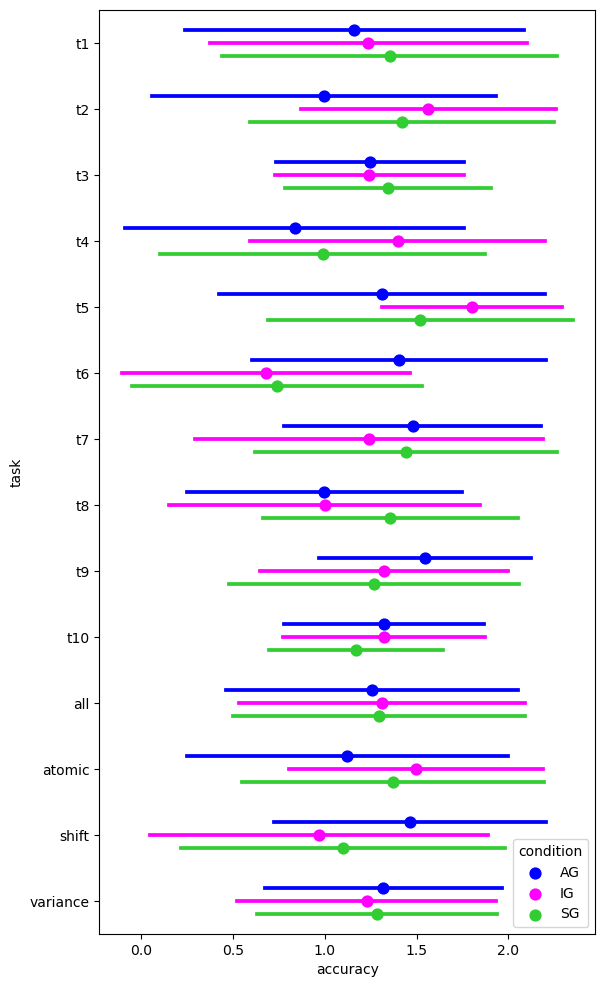

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure().set_figheight(12)
p = {'AG':'blue','IG':'magenta','SG':'#32CD32'}
sns.pointplot(df, x = 'accuracy', y='task', hue = 'condition', join=False, errorbar = 'sd', palette = p, hue_order = ['AG','IG','SG'], dodge = 0.4)

### Plot Posterior Predictive Distributions

In [46]:
import pandas as pd
pp_acc_T1_multi_cat['accuracyIG']#[:,0:110][0]
# pp_acc_T1_multi_cat
# d_cat = az.from_pymc3(trace_acc_T1_multi_cat, posterior_predictive = pp_acc_T1_multi_cat)
d_cat
data_categ = {'condition':[], 'accuracy':[]}
for i in pp_acc_T1_multi_cat['accuracyIG'].flatten():
    data_categ['condition'].append('i')
    data_categ['accuracy'].append(str(i))
    data_categ['condition'].append('all')
    data_categ['accuracy'].append(str(i))
for i in pp_acc_T1_multi_cat['accuracySG'].flatten():
    data_categ['condition'].append('s')
    data_categ['accuracy'].append(str(i))
    data_categ['condition'].append('all')
    data_categ['accuracy'].append(str(i))
for i in pp_acc_T1_multi_cat['accuracyAG'].flatten():
    data_categ['condition'].append('a')
    data_categ['accuracy'].append(str(i))
    data_categ['condition'].append('all')
    data_categ['accuracy'].append(str(i))

df = pd.DataFrame(data_categ)

<AxesSubplot: xlabel='accuracy', ylabel='Probability'>

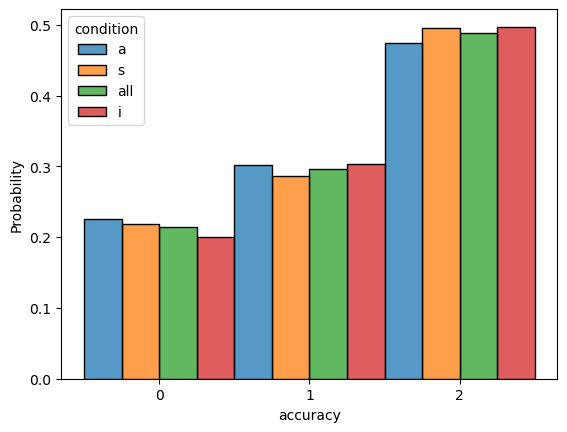

In [56]:
sns.histplot(df.sort_values(['accuracy']),stat='probability',x="accuracy",hue='condition',common_norm = False,multiple="dodge")

### Plot Categorical p

In [9]:
import arviz as az
## posterior pred
pp_reshape = pp_acc_T1_multi_cat['accuracyIG'][:,0:110].reshape(2000,10,11)
pp_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pp_reoredered[t] = pp_reshape[:,t_i,:].flatten()
data_pp = az.convert_to_dataset(pp_reoredered) 
# az.plot_forest(trace_acc_T1_multi_cat, combined = True)
## posterior p
hamm = 2
pIG_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pIG_reoredered[t] = trace_acc_T1_multi_cat['pIG'][:,t_i,hamm].flatten()
data_pIG = az.convert_to_dataset(pIG_reoredered) 

pSG_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pSG_reoredered[t] = trace_acc_T1_multi_cat['pSG'][:,t_i,hamm].flatten()
data_pSG = az.convert_to_dataset(pSG_reoredered) 


pAG_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pAG_reoredered[t] = trace_acc_T1_multi_cat['pAG'][:,t_i,hamm].flatten()
data_pAG = az.convert_to_dataset(pAG_reoredered) 


Text(0.5, 0, 'SG-AG')

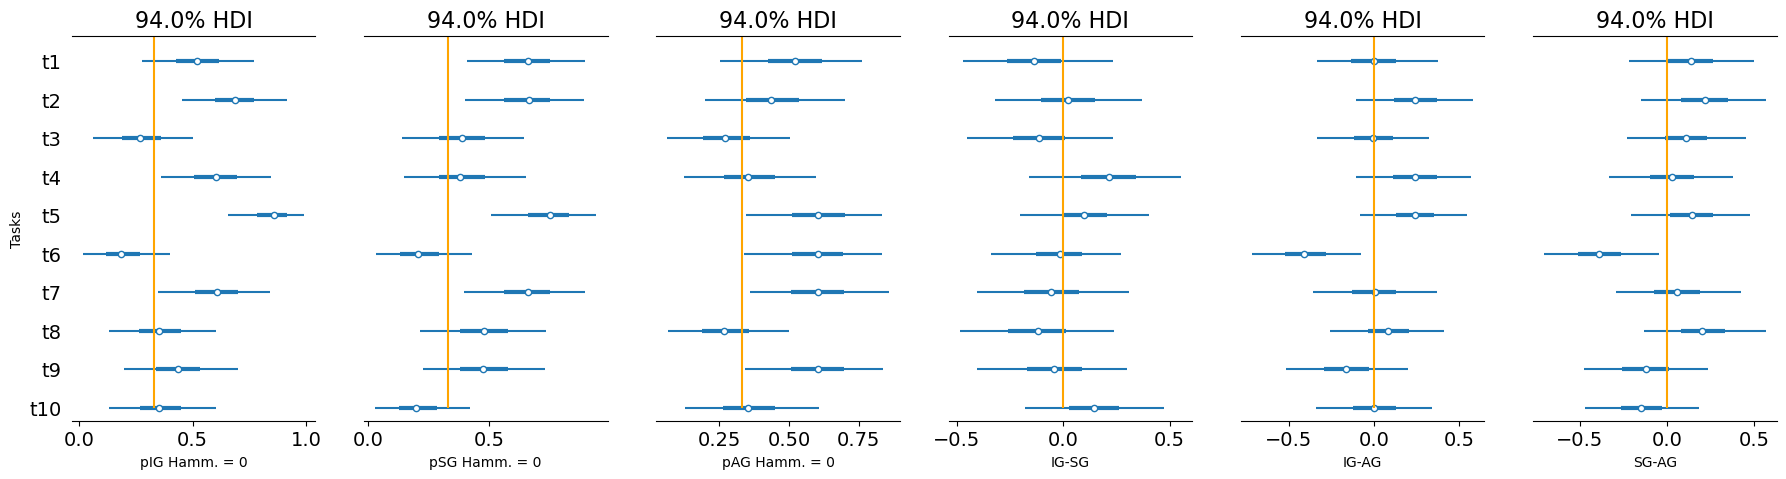

In [10]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
# ai = az.from_pymc3(trace_acc_T2_singl)
# ai['posterior']
y_max = 40
az.plot_forest(data_pIG, ax = ax[0], combined = True)
ax[0].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pSG, ax = ax[1], combined = True)
ax[1].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pAG, ax = ax[2], combined = True)
ax[2].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pIG-data_pSG, ax = ax[3], combined = True)
ax[3].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pIG-data_pAG, ax = ax[4], combined = True)
ax[4].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pSG-data_pAG, ax = ax[5], combined = True)
ax[5].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("pIG Hamm. = 0")
ax[1].set_xlabel("pSG Hamm. = 0")
ax[2].set_xlabel("pAG Hamm. = 0")
ax[3].set_xlabel("IG-SG")
ax[4].set_xlabel("IG-AG")
ax[5].set_xlabel("SG-AG")

# Bayesian Analysis of Collected Data

## Inference for T1

### Response Times

In [8]:
# interactive and static response times
t_id = t_ids['T1']
t_id.extend(t_ids['T2'])

tim_i = [j for tt in times_i for _,value in times_i[tt].items() for j in value]
tim_s = [j for tt in times_s for _,value in  times_s[tt].items() for j in value]
tim_a = [j for tt in times_a for _,value in  times_a[tt].items() for j in value]
#indices
t_indices_i = [t_id.index(t) 
               for tt in times_i
               for t,value in times_i[tt].items() 
               for j in value]
t_indices_s = [t_id.index(t) 
               for tt in times_s
               for t,value in times_s[tt].items() 
               for j in value]
t_indices_a = [t_id.index(t) 
               for tt in times_a
               for t,value in times_a[tt].items() 
               for j in value]
trace_rt_T1, pp_rt_T1 = get_times_inference(tim_i, tim_s, tim_a, 
                                              t_indices_i, t_indices_s, t_indices_a,
                                              t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupAG_std, groupAG_mean, groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.


Text(0.5, 0, 'SG-AG')

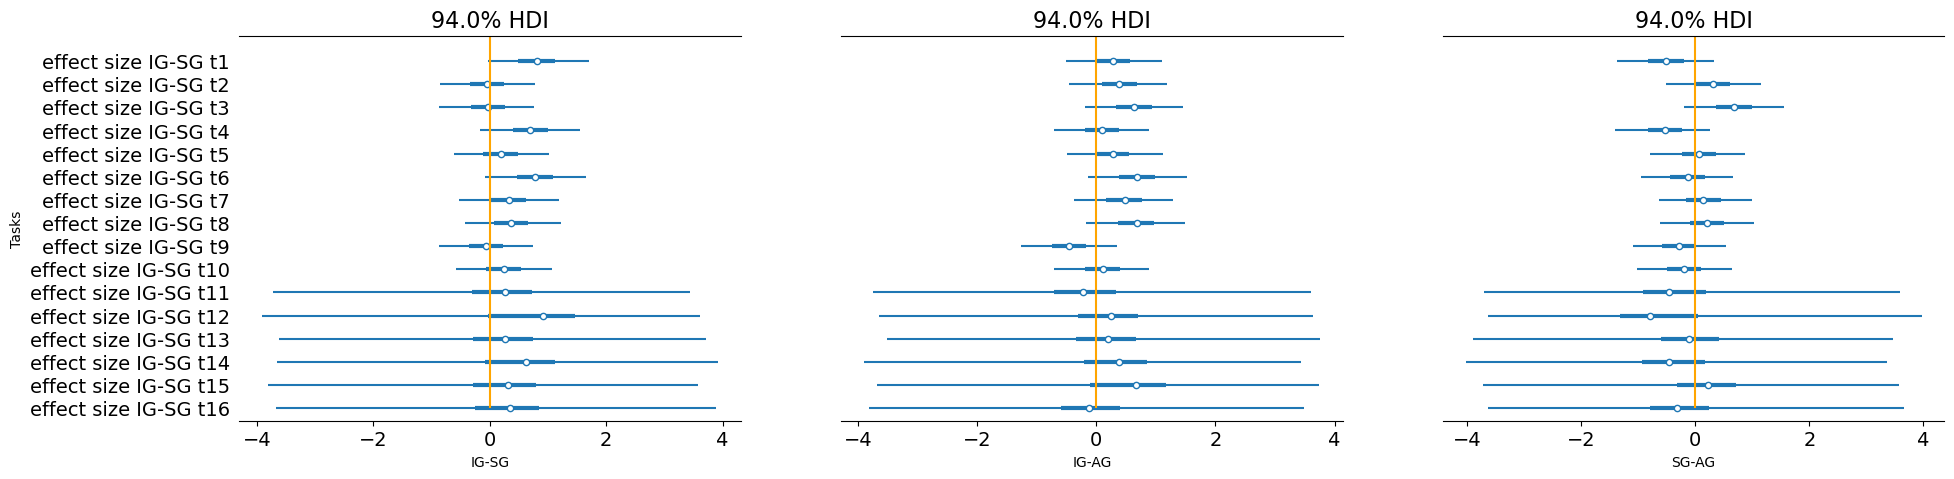

In [9]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(22, 5))
ai = az.from_pymc3(trace_rt_T1)
# ai['posterior']
az.plot_forest(ai['posterior']['effect size IG-SG'], ax = ax[0], combined = True)
ax[0].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['effect size IG-AG'], ax = ax[1], combined = True)
ax[1].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['effect size SG-AG'], ax = ax[2], combined = True)
ax[2].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')


##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("IG-SG")
ax[1].set_xlabel("IG-AG")
ax[2].set_xlabel("SG-AG")

### Confidence

In [6]:
# interactive and static response times
t_id = t_ids['T1']
t_id.extend(t_ids['T2'])
c_i = [j for tt in conf_i for _,value in conf_i[tt].items() 
       for j in value]
c_s = [j for tt in conf_s for _,value in conf_s[tt].items() 
       for j in value]
c_a = [j for tt in conf_a for _,value in conf_a[tt].items() 
       for j in value]
#indices
t_indices_i = [t_id.index(t) 
               for tt in conf_i
               for t,value in conf_i[tt].items() 
               for j in value]
t_indices_s = [t_id.index(t) 
               for tt in conf_s
               for t,value in conf_s[tt].items() 
               for j in value]
t_indices_a = [t_id.index(t) 
               for tt in conf_a
               for t,value in conf_a[tt].items() 
               for j in value]
trace_conf_T1, pp_conf_T1 = get_confidence_inference(c_i, c_s, c_a,
                                                       t_indices_i, t_indices_s, t_indices_a, 
                                                       t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupAG_std, groupAG_mean, groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


Text(0.5, 0, 'SG-AG')

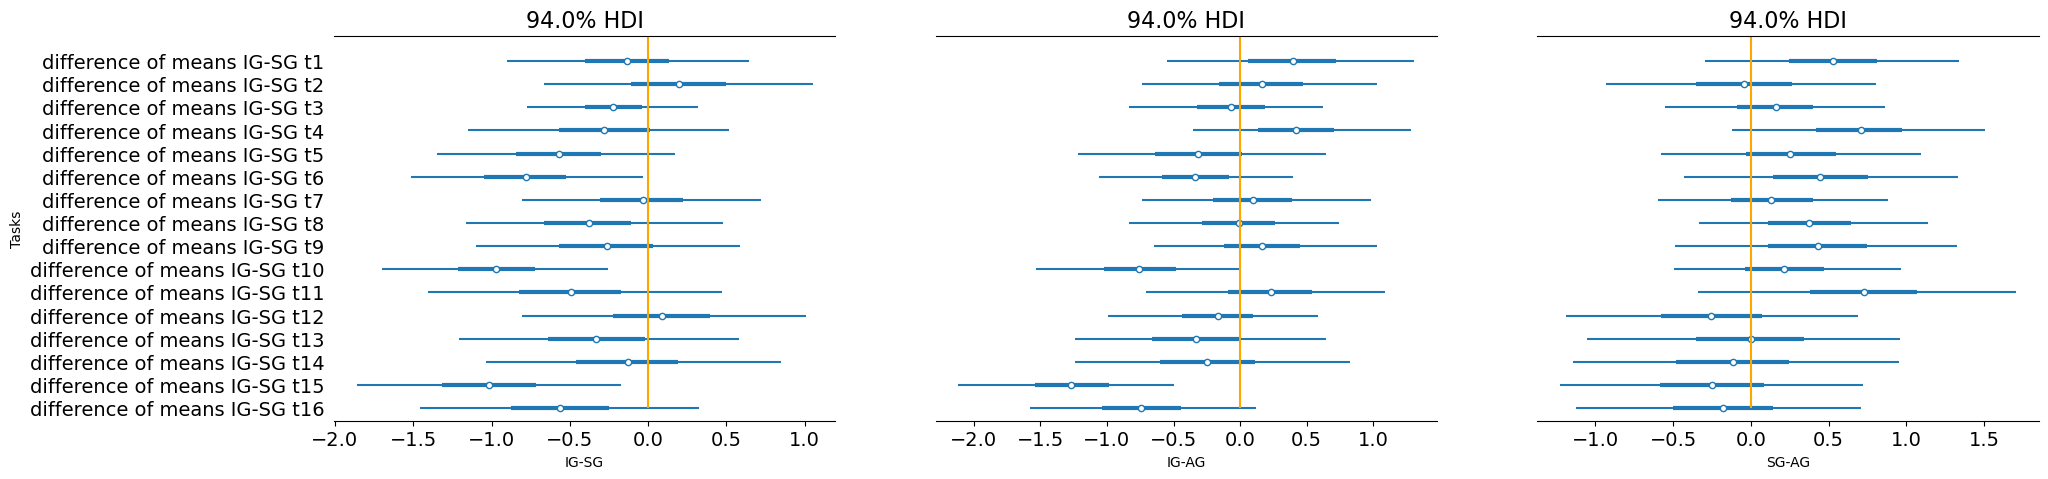

In [7]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(22, 5))
ai = az.from_pymc3(trace_conf_T1)
# ai['posterior']
az.plot_forest(ai['posterior']['difference of means IG-SG'], ax = ax[0], combined = True)
ax[0].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of means IG-AG'], ax = ax[1], combined = True)
ax[1].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of means SG-AG'], ax = ax[2], combined = True)
ax[2].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')


##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("IG-SG")
ax[1].set_xlabel("IG-AG")
ax[2].set_xlabel("SG-AG")

### Accuracy
We model the probability of making a mistake in identifying the existence or not of a relation.

In [10]:
# number of trials (available options) per task in rq1
n_sizes_per_task = {'t1':3,'t6':3,'t12':4,'t13':3}
n_i = [n_sizes_per_task[t] 
       for t,value in corr_answers_i['rq1'].items() 
       for j in value]
n_s = [n_sizes_per_task[t] 
       for t,value in corr_answers_s['rq1'].items() 
       for j in value]
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq1'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq1'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_s['rq1'].items() 
               for j in value]
trace_acc_rq1, pp_acc_rq1 = get_answers_rq1_inference(ans_i, 
                                                      ans_s, n_i, n_s, 
                                                      t_indices_i, 
                                                      t_indices_s, 
                                                      t_ids['rq1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


## Inference for RQ2

### Response Times

In [12]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq2'].items() 
         for j in value]
tim_s = [j for _,value in  times_s['rq2'].items() 
         for j in value]
#indices
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in times_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in times_s['rq2'].items() 
               for j in value]
trace_rt_rq2, pp_rt_rq2 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


### Accuracy

In [13]:
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq2'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq2'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in corr_answers_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in corr_answers_s['rq2'].items() 
               for j in value]

trace_acc_rq2, pp_acc_rq2 = get_answers_rq2_3_inference(ans_i, 
                                                        ans_s, 
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


### Confidence

In [14]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq2'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq2'].items() 
       for j in value]
#indexes
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in conf_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in conf_s['rq2'].items() 
               for j in value]
trace_conf_rq2, pp_conf_rq2 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


## Inference for RQ3

### Response Times

In [15]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq3'].items() 
         for j in value]
tim_s = [j for _,value in  times_s['rq3'].items() 
         for j in value]
#indices
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in times_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in times_s['rq3'].items() 
               for j in value]
trace_rt_rq3, pp_rt_rq3 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


### Accuracy

In [16]:
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq3'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq3'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in corr_answers_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in corr_answers_s['rq3'].items() 
               for j in value]

trace_acc_rq3, pp_acc_rq3 = get_answers_rq2_3_inference(ans_i, 
                                                        ans_s, 
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


### Confidence

In [17]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq3'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq3'].items() 
       for j in value]
#indexes
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in conf_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in conf_s['rq3'].items() 
               for j in value]
trace_conf_rq3, pp_conf_rq3 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


## Inference for Number of Selection Boxes

In [18]:
## observed numbers of boxes
num_boxes = [j for array in num_of_boxes 
               for j in array]
## indices 
t_indices = [i for i,array in enumerate(num_of_boxes) 
               for j in array]
## inference
trace_num_boxes, pp_num_boxes = get_num_boxes_inference(num_boxes, 
                                                        t_ids_all,  
                                                        t_indices)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, psi]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.


## Inference for Length of Selection Boxes

In [19]:
## observed numbers of boxes
len_boxes = [j for array in len_of_boxes 
               for j in array]
## indices 
t_indices = [i for i,array in enumerate(len_of_boxes) 
               for j in array]
## inference
trace_len_boxes, pp_len_boxes = get_len_boxes_inference(len_boxes, 
                                                        t_ids_all,  
                                                        t_indices)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.


# Visualizations

### Pair Plot of Means of Posteriors of Differences for Accuracy-Response Times-Confidence

posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not

<Figure size 640x480 with 0 Axes>

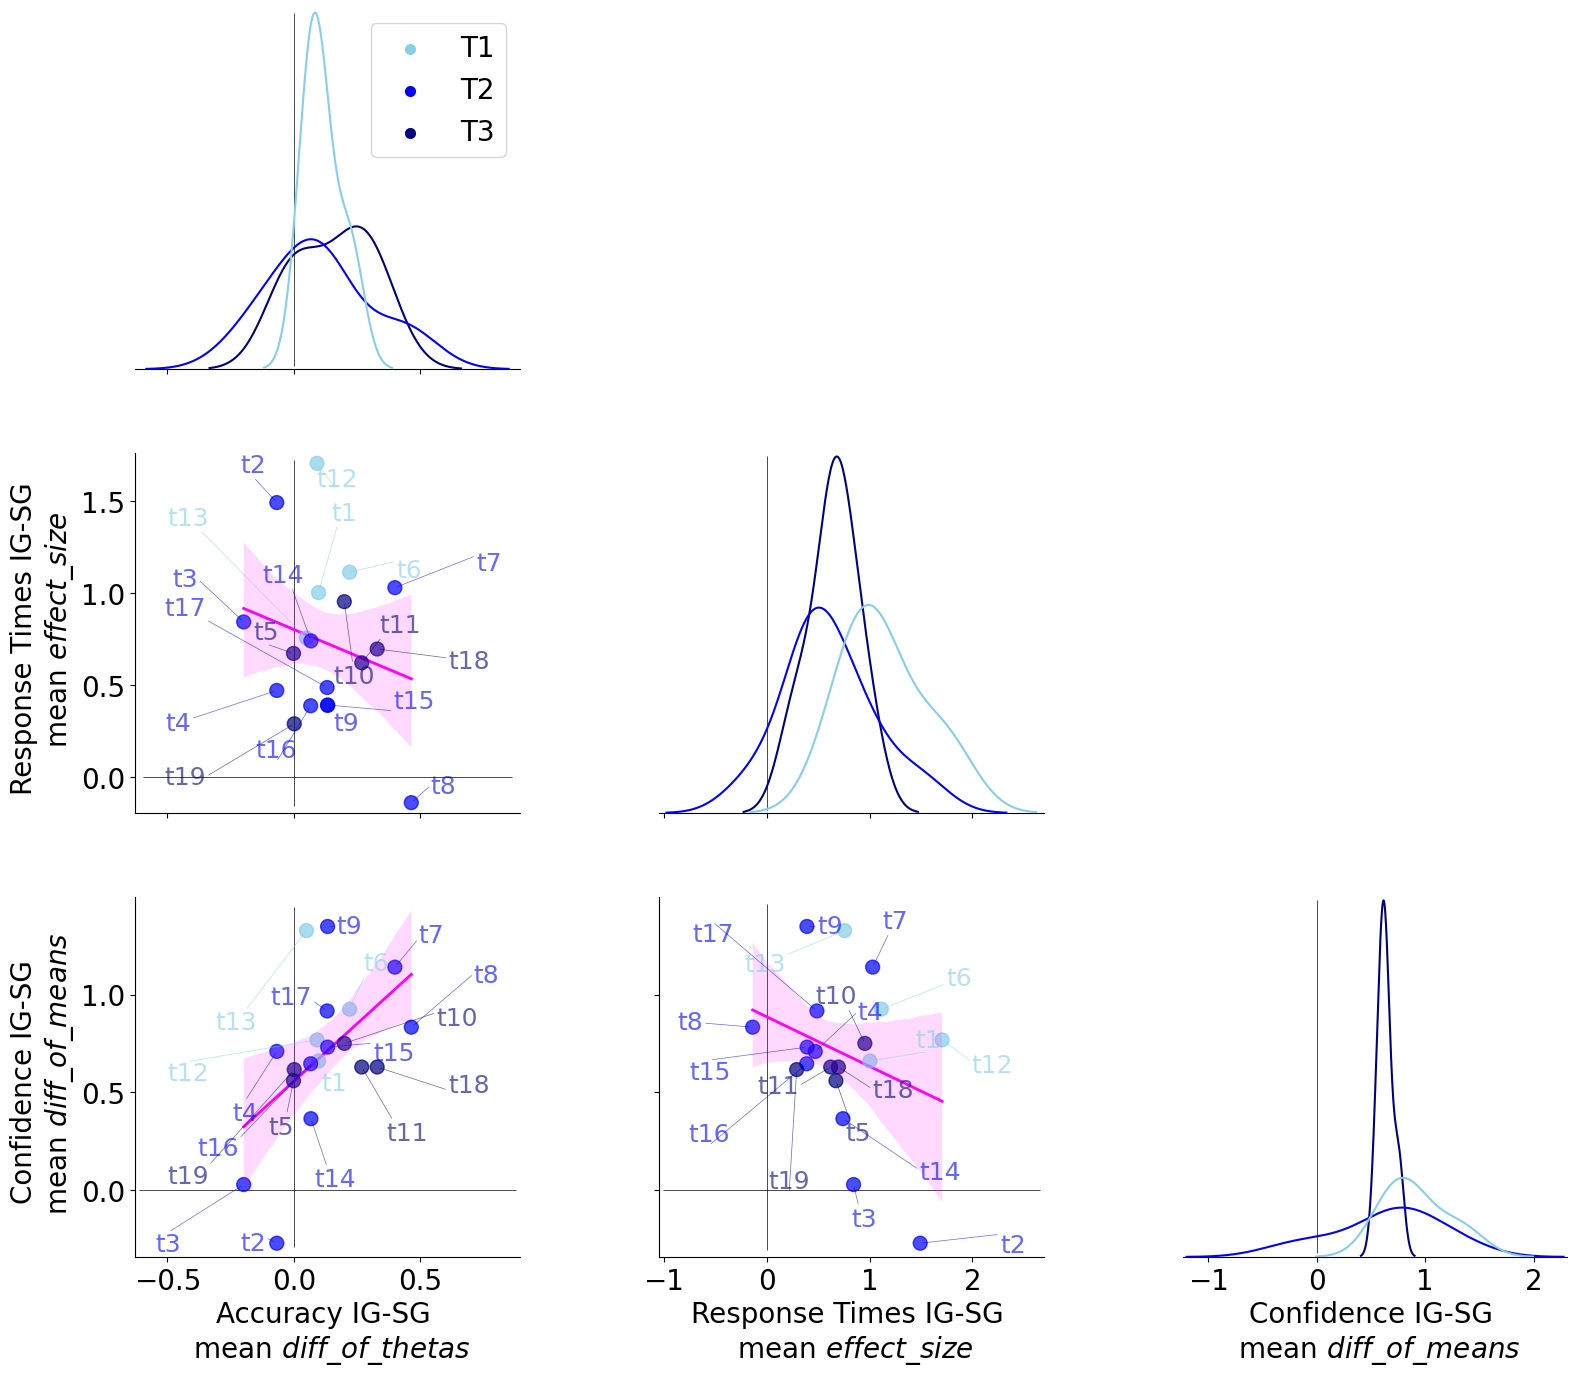

In [20]:
# data preparation
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc_rq1'] = (trace_acc_rq1,pp_acc_rq1,"difference of thetas")
traces_dict['acc_rq2'] = (trace_acc_rq2,pp_acc_rq2,"difference of thetas")
traces_dict['acc_rq3'] = (trace_acc_rq3,pp_acc_rq3,"difference of thetas")
traces_dict['rt_rq1'] = (trace_rt_rq1,pp_rt_rq1,"effect size")
traces_dict['rt_rq2'] = (trace_rt_rq2,pp_rt_rq2,"effect size")
traces_dict['rt_rq3'] = (trace_rt_rq3,pp_rt_rq3,"effect size")
traces_dict['conf_rq1'] = (trace_conf_rq1,pp_conf_rq1,"difference of means")
traces_dict['conf_rq2'] = (trace_conf_rq2,pp_conf_rq2,"difference of means")
traces_dict['conf_rq3'] = (trace_conf_rq3,pp_conf_rq3,"difference of means")
#
df, pp_data = get_data_response_pair_plot(t_ids, traces_dict)
pair_plot_of_means(df, pp_data)

## Combined Forest Plot of Inference Results for Accuracy-Response Times-Confidence

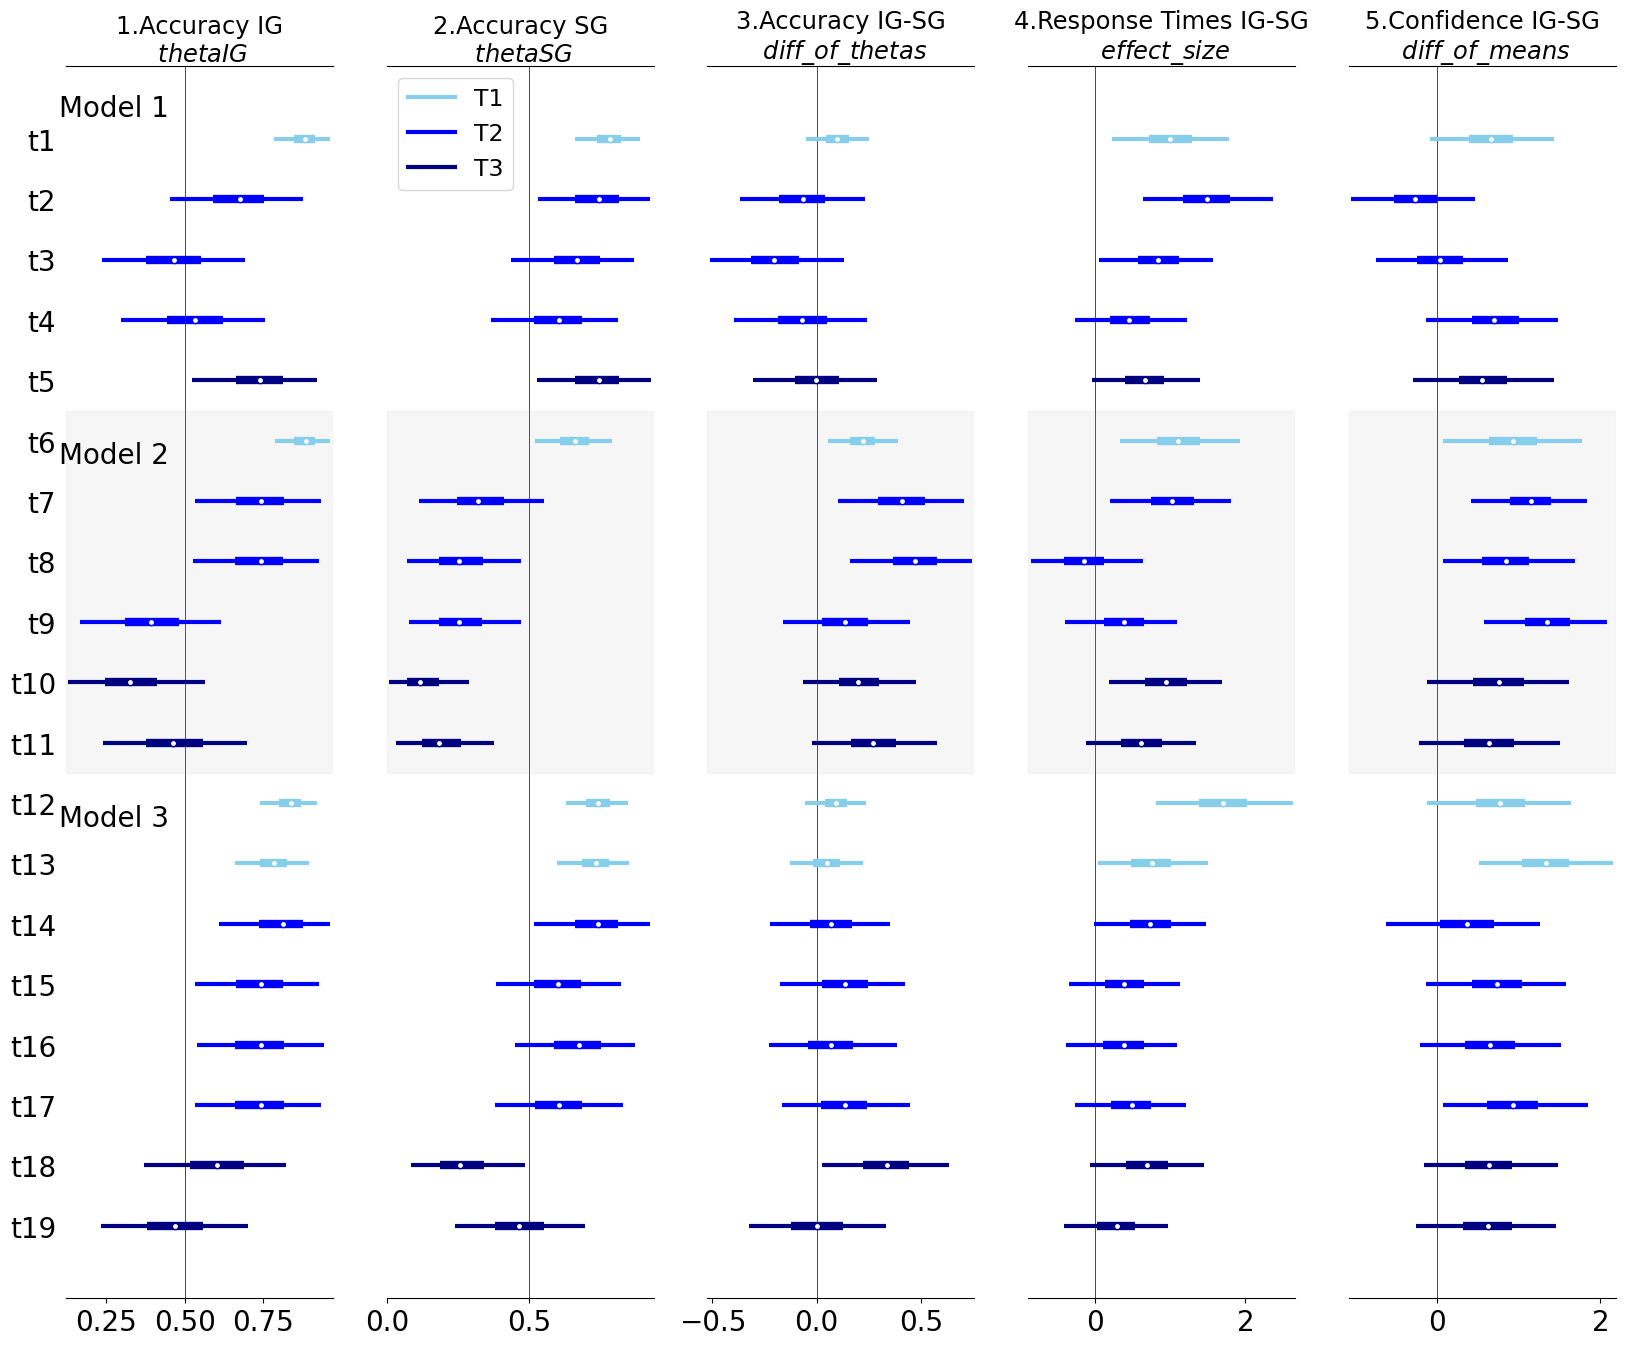

In [21]:
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc'] = [trace_acc_rq1, trace_acc_rq2, trace_acc_rq3]
traces_dict['rt'] = [trace_rt_rq1, trace_rt_rq2, trace_rt_rq3]
traces_dict['conf'] = [trace_conf_rq1, trace_conf_rq2, trace_conf_rq3]
forrest_plot_data = get_data_forest_plot(traces_dict)
#
axes = combined_forest_plot(forrest_plot_data)

## Ordered Combined Forest Plot of Inference Results for Accuracy-Response Times-Confidence

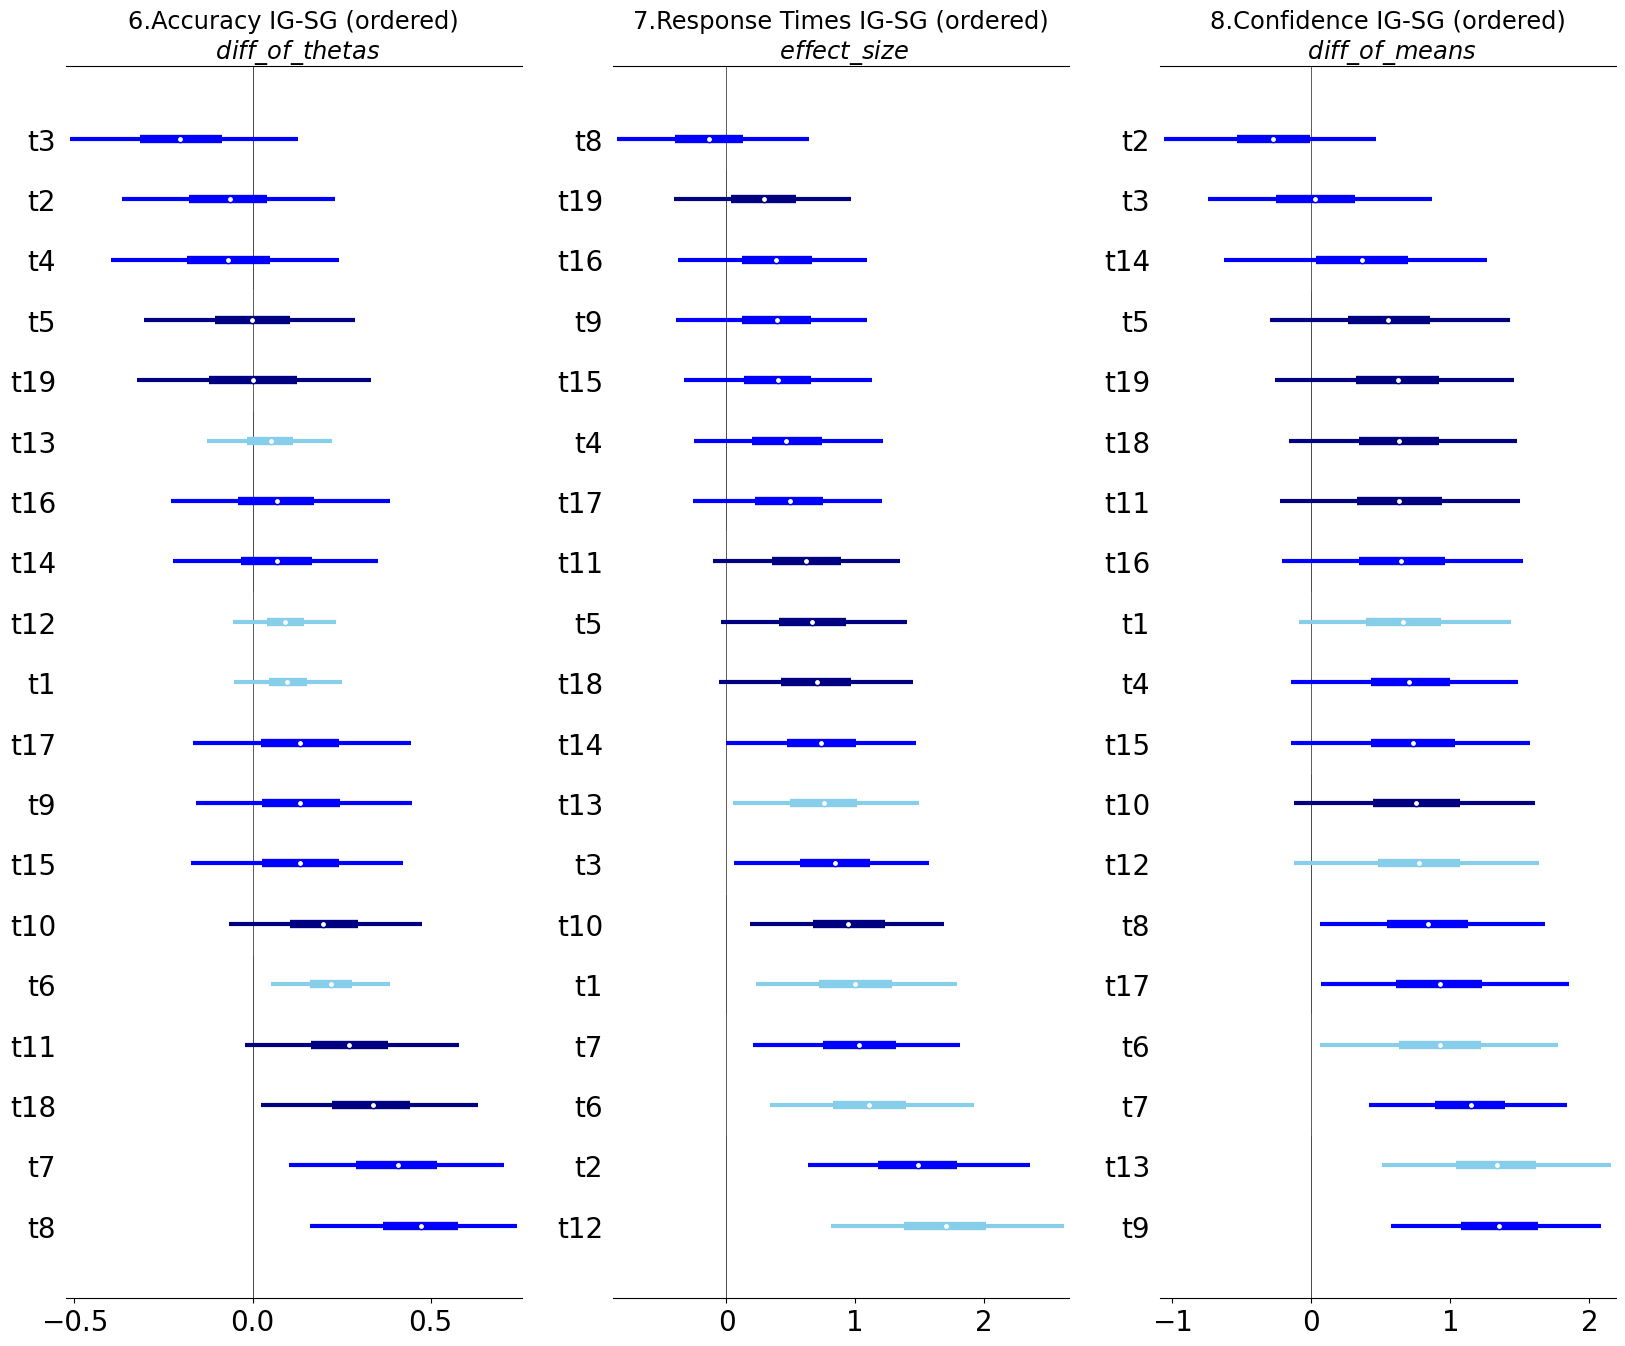

In [22]:
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc'] = [trace_acc_rq1, trace_acc_rq2, trace_acc_rq3]
traces_dict['rt'] = [trace_rt_rq1, trace_rt_rq2, trace_rt_rq3]
traces_dict['conf'] = [trace_conf_rq1, trace_conf_rq2, trace_conf_rq3]
forrest_plot_data = get_data_ordered_forest_plot(traces_dict)
#
axes = combined_oredered_forest_plot(forrest_plot_data)

## Quartiles of Observed Number and Length of Selection Boxes drawn

In [23]:
num_list = [el for array in num_of_boxes for el in array]  
mean_observed_num_of_boxes =  sum(num_list) / len(num_list)
print(mean_observed_num_of_boxes)
num_percentiles = np.percentile(num_list, [25, 50, 75])
print(num_percentiles)

#
len_list = [el for array in len_of_boxes for el in array]  
mean_observed_len_of_boxes =  sum(len_list) / len(len_list)
print(mean_observed_len_of_boxes)
len_percentiles = np.percentile(len_list, [25, 50, 75])
print(len_percentiles)

10.20242914979757
[ 4.5  9.  13. ]
0.18873438168655182
[0.10740741 0.16319614 0.2421004 ]


## Combined Forest Plot of Inference Results for Accuracy-Response Times-Confidence and Inference Results and Observations of Number and Length of Selection Boxes

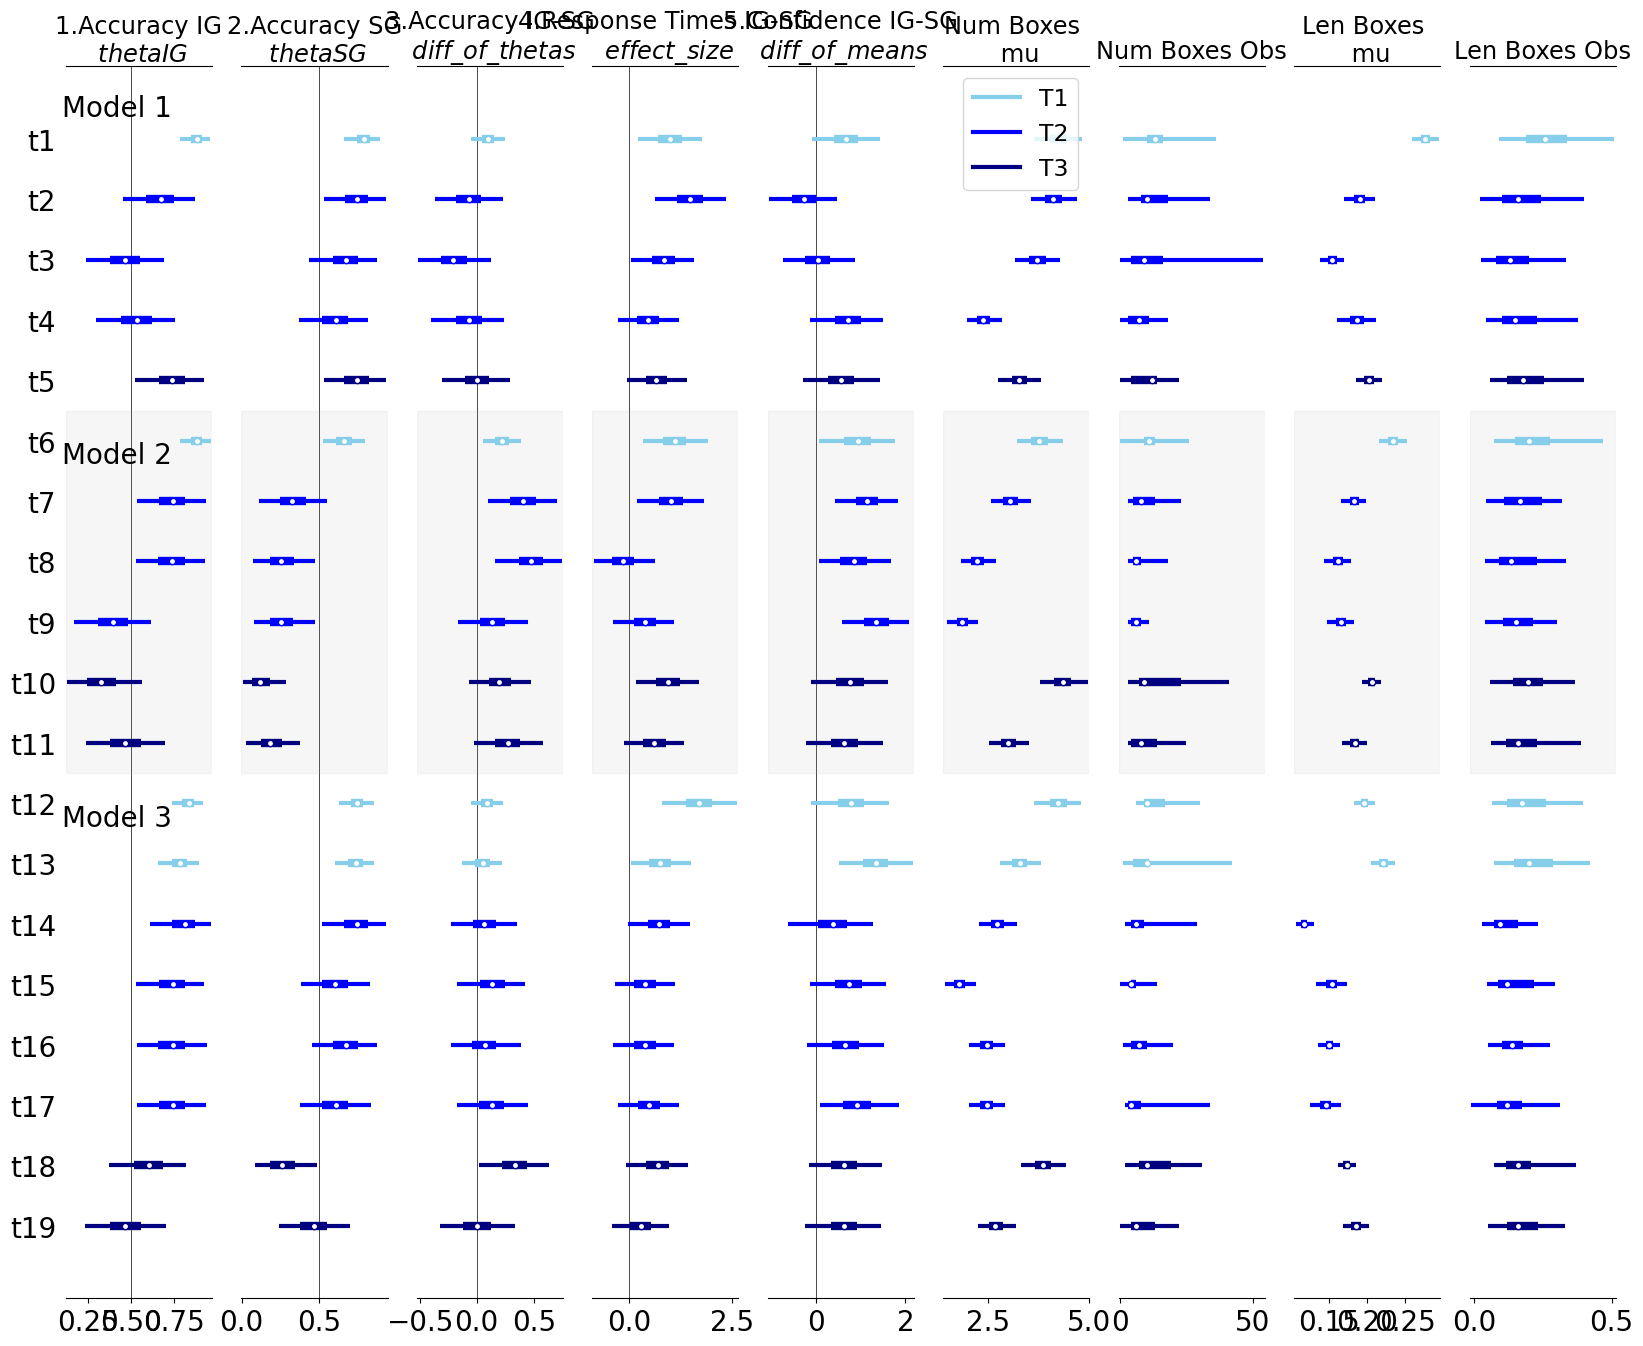

array([<AxesSubplot:title={'center':'1.Accuracy IG\n $\\it{thetaIG}$'}>,
       <AxesSubplot:title={'center':'2.Accuracy SG\n $\\it{thetaSG}$'}>,
       <AxesSubplot:title={'center':'3.Accuracy IG-SG\n $\\it{diff\\_of\\_thetas}$'}>,
       <AxesSubplot:title={'center':'4.Response Times IG-SG\n $\\it{effect\\_size}$'}>,
       <AxesSubplot:title={'center':'5.Confidence IG-SG\n $\\it{diff\\_of\\_means}$'}>,
       <AxesSubplot:title={'center':'Num Boxes \n mu'}>,
       <AxesSubplot:title={'center':'Num Boxes Obs'}>,
       <AxesSubplot:title={'center':'Len Boxes \n mu'}>,
       <AxesSubplot:title={'center':'Len Boxes Obs'}>], dtype=object)

In [24]:
traces_dict['num_boxes_obs'] = num_of_boxes
traces_dict['len_boxes_obs'] = len_of_boxes
traces_dict['num_boxes'] = [trace_num_boxes]
traces_dict['len_boxes'] = [trace_len_boxes]
#
forrest_plot_data_int = get_data_forest_plot(traces_dict)
combined_forest_plot(forrest_plot_data_int)

## Scatter Plot of Inferred Mean Values of Number and Length of Selection Boxes

In [25]:
# means of traces of hierarchical models
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc_rq1'] = (trace_acc_rq1,pp_acc_rq1,"difference of thetas")
traces_dict['acc_rq2'] = (trace_acc_rq2,pp_acc_rq2,"difference of thetas")
traces_dict['acc_rq3'] = (trace_acc_rq3,pp_acc_rq3,"difference of thetas")
traces_dict['rt_rq1'] = (trace_rt_rq1,pp_rt_rq1,"effect size")
traces_dict['rt_rq2'] = (trace_rt_rq2,pp_rt_rq2,"effect size")
traces_dict['rt_rq3'] = (trace_rt_rq3,pp_rt_rq3,"effect size")
traces_dict['conf_rq1'] = (trace_conf_rq1,pp_conf_rq1,"difference of means")
traces_dict['conf_rq2'] = (trace_conf_rq2,pp_conf_rq2,"difference of means")
traces_dict['conf_rq3'] = (trace_conf_rq3,pp_conf_rq3,"difference of means")
traces_dict['num_boxes'] = (trace_num_boxes,pp_num_boxes,"mu")
traces_dict['len_boxes'] = (trace_len_boxes,pp_len_boxes,"mu")
# dict of means of traces
means = get_means_from_traces(traces_dict)

posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not

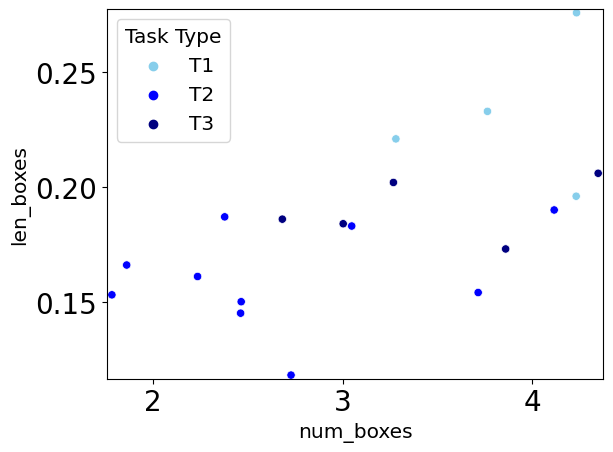

In [26]:
df_num_len_box = get_data_interaction_scatter_plot(means)
scatter_plot_of_num_len_boxes(df_num_len_box)

## Pair Plot of Means of Posteriors of Differences for Accuracy-Response Times-Confidence and Means of Posteriors of Mean Number and Lenght of Selection Boxes

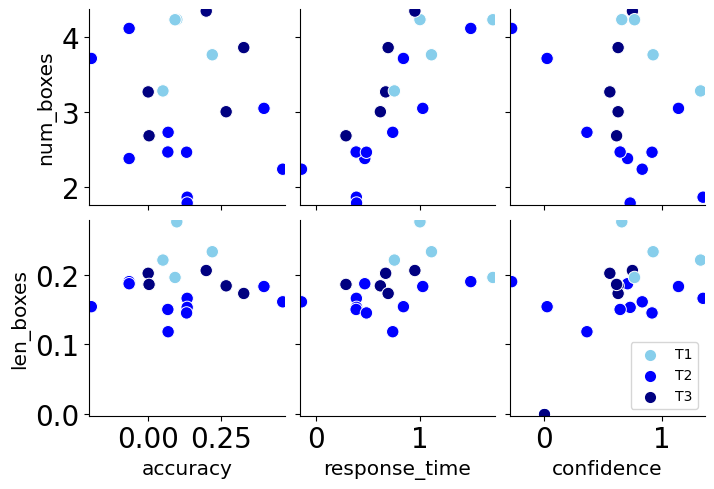

In [27]:
df_means_num, pp_data_num = get_data_response_interaction_pair_plot(means)
pair_plot_response_interaction(df_means_num, pp_data_num)